In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 90)
import matplotlib.pyplot as plt
import seaborn as sns
PALETTE = ['#dd4124','#009473', '#b4b4b4', '#336b87']
BACKCOLOR = '#f6f5f5'
sns.set_palette(PALETTE)

from scipy.stats import norm, probplot, skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.neighbors import  KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix

from IPython.core.display import HTML

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# When exploring a dataset, it is recommended to use the entire data.
all_data = pd.concat((train, test)).reset_index(drop=True)

In [5]:
all_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [8]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns])

,PassengerId
1,1
861,1
879,1
878,1
877,1
...,...
436,1
435,1
434,1
433,1


In [9]:
numerical_vars = ['Age', 'SibSp', 'Parch', 'Fare']
ordinal_vars = ['Pclass']
nominal_vars = ['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [10]:
train0 = train[train.Survived == 0]
train1 = train[train.Survived == 1]
cnt = 0
detail_desc = []
for c in train.columns:
    if c == 'PassengerId':
        continue
    if train[c].dtypes != 'object':
        desc = pd.DataFrame(columns=['feature', 'data', 'type', 'count', 'mean', 'median', 'std', 'min', 'max', 'skew', 'null'])
        desc.loc[0] = [c, 'Train', train[c].dtype.name, train[c].count(), train[c].mean(), train[c].median(), train[c].std(), train[c].min(), train[c].max(), train[c].skew(), train[c].isnull().sum()]
        desc.loc[1] = [c, 'All', train[c].dtype.name, all_data[c].count(), all_data[c].mean(), all_data[c].median(), all_data[c].std(), all_data[c].min(), all_data[c].max(), all_data[c].skew(), all_data[c].isnull().sum()]
        desc.loc[2] = [c, 'Target=0', train0[c].dtype.name, train0[c].count(), train0[c].mean(), train0[c].median(), train0[c].std(), train0[c].min(), train0[c].max(), train0[c].skew(), train0[c].isnull().sum()]      
        desc.loc[3] = [c, 'Target=1', train1[c].dtype.name, train1[c].count(), train1[c].mean(), train1[c].median(), train1[c].std(), train1[c].min(), train1[c].max(), train1[c].skew(), train1[c].isnull().sum()]
        desc = desc.set_index(['feature', 'data'],drop=True)
        detail_desc.append(desc.style.background_gradient())

In [11]:
train0 = train[train.Survived == 0]
train1 = train[train.Survived == 1]
cnt = 0
detail_desc = []
for c in train.columns:
    if c == 'PassengerId':
        continue
    if train[c].dtypes == 'object':
        desc = pd.DataFrame(columns=['feature', 'data', 'type', 'count', 'null', 'mode', 'value_count'])
        desc.loc[0] = [c, 'Train', train[c].dtype.name, train[c].count(), train[c].isnull().sum(), train[c].mode(), train[c].value_counts()]
        #desc.loc[1] = [c, 'All', train[c].dtype.name, all_data[c].count(), all_data[c].mean(), all_data[c].median(), all_data[c].std(), all_data[c].min(), all_data[c].max(), all_data[c].skew(), all_data[c].isnull().sum()]
        #desc.loc[2] = [c, 'Target=0', train0[c].dtype.name, train0[c].count(), train0[c].mean(), train0[c].median(), train0[c].std(), train0[c].min(), train0[c].max(), train0[c].skew(), train0[c].isnull().sum()]      
        #desc.loc[3] = [c, 'Target=1', train1[c].dtype.name, train1[c].count(), train1[c].mean(), train1[c].median(), train1[c].std(), train1[c].min(), train1[c].max(), train1[c].skew(), train1[c].isnull().sum()]
        desc = desc.set_index(['feature', 'data'],drop=True)
        detail_desc.append(desc.style.background_gradient())

In [12]:
multi_table(detail_desc)

,,type,count,null,mode,value_count
feature,data,,,,,
Name,Train,object,891,0,"0 Abbing, Mr. Anthony 1 Abbott, Mr. Rossmore Edward 2 Abbott, Mrs. Stanton (Rosa Hunt) 3 Abelson, Mr. Samuel 4 Abelson, Mrs. Samuel (Hannah Wizosky) ... 886 de Mulder, Mr. Theodore 887 de Pelsmaeker, Mr. Alfons 888 del Carlo, Mr. Sebastiano 889 van Billiard, Mr. Austin Blyler 890 van Melkebeke, Mr. Philemon Length: 891, dtype: object","Braund, Mr. Owen Harris 1 Boulos, Mr. Hanna 1 Frolicher-Stehli, Mr. Maxmillian 1 Gilinski, Mr. Eliezer 1 Murdlin, Mr. Joseph 1 .. Kelly, Miss. Anna Katherine ""Annie Kate"" 1 McCoy, Mr. Bernard 1 Johnson, Mr. William Cahoone Jr 1 Keane, Miss. Nora A 1 Dooley, Mr. Patrick 1 Name: Name, Length: 891, dtype: int64"
,,type,count,null,mode,value_count
feature,data,,,,,
Sex,Train,object,891,0,0 male dtype: object,"male 577 female 314 Name: Sex, dtype: int64"
,,type,count,null,mode,value_count
feature,data,,,,,
Ticket,Train,object,891,0,0 1601 1 347082 2 CA. 2343 dtype: object,"347082 7 CA. 2343 7 1601 7 3101295 6 CA 2144 6 .. 9234 1 19988 1 2693 1 PC 17612 1 370376 1 Name: Ticket, Length: 681, dtype: int64"
,,type,count,null,mode,value_count
feature,data,,,,,


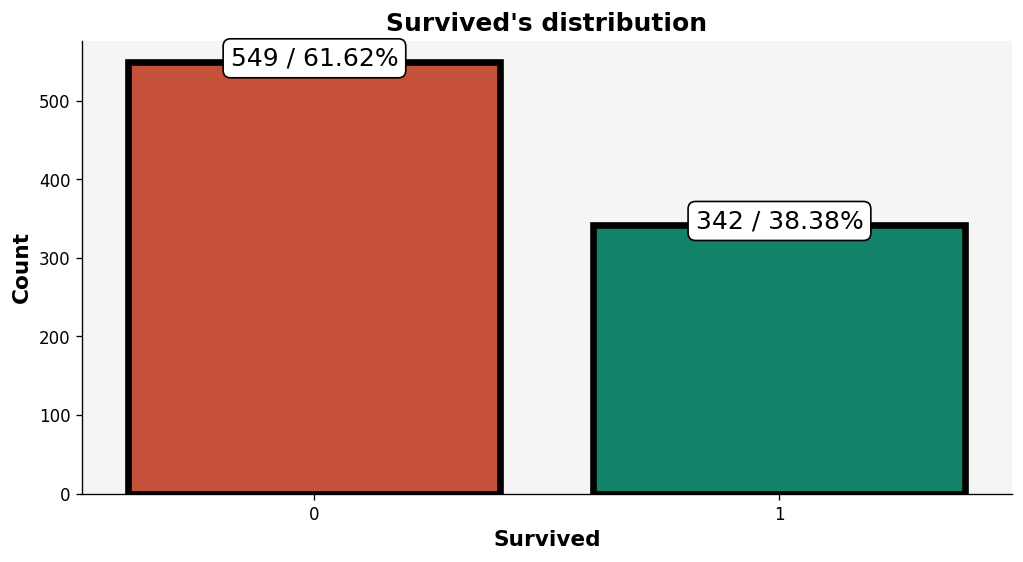

In [13]:
total_cnt = train.Survived.count()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(train.Survived, edgecolor='black', linewidth=4, ax=ax)
ax.set_xlabel('Survived', weight='bold', size=13)
ax.set_ylabel('Count', weight='bold', size=13)
ax.set_facecolor(BACKCOLOR)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title(f"Survived's distribution", size=15, weight='bold')
for patch in ax.patches:
    x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
    ax.text(x + width / 2, height + 5, f'{height} / {height / total_cnt * 100:2.2f}%', va='center', ha='center', size=15, bbox={'facecolor': 'white', 'boxstyle': 'round'})

plt.show()

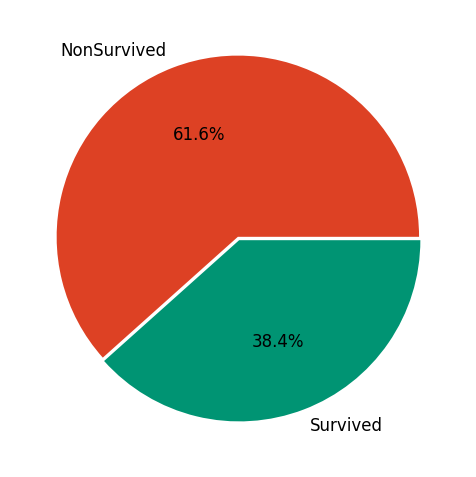

In [14]:
f, ax = plt.subplots(1,1,figsize=(15, 5))
ax.pie(train.Survived.value_counts(),
       explode=[.01,.01],
       labels=['NonSurvived', 'Survived'],
       autopct='%1.1f%%',
       
)
plt.show()

In [15]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=4, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines[['top', 'right']].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

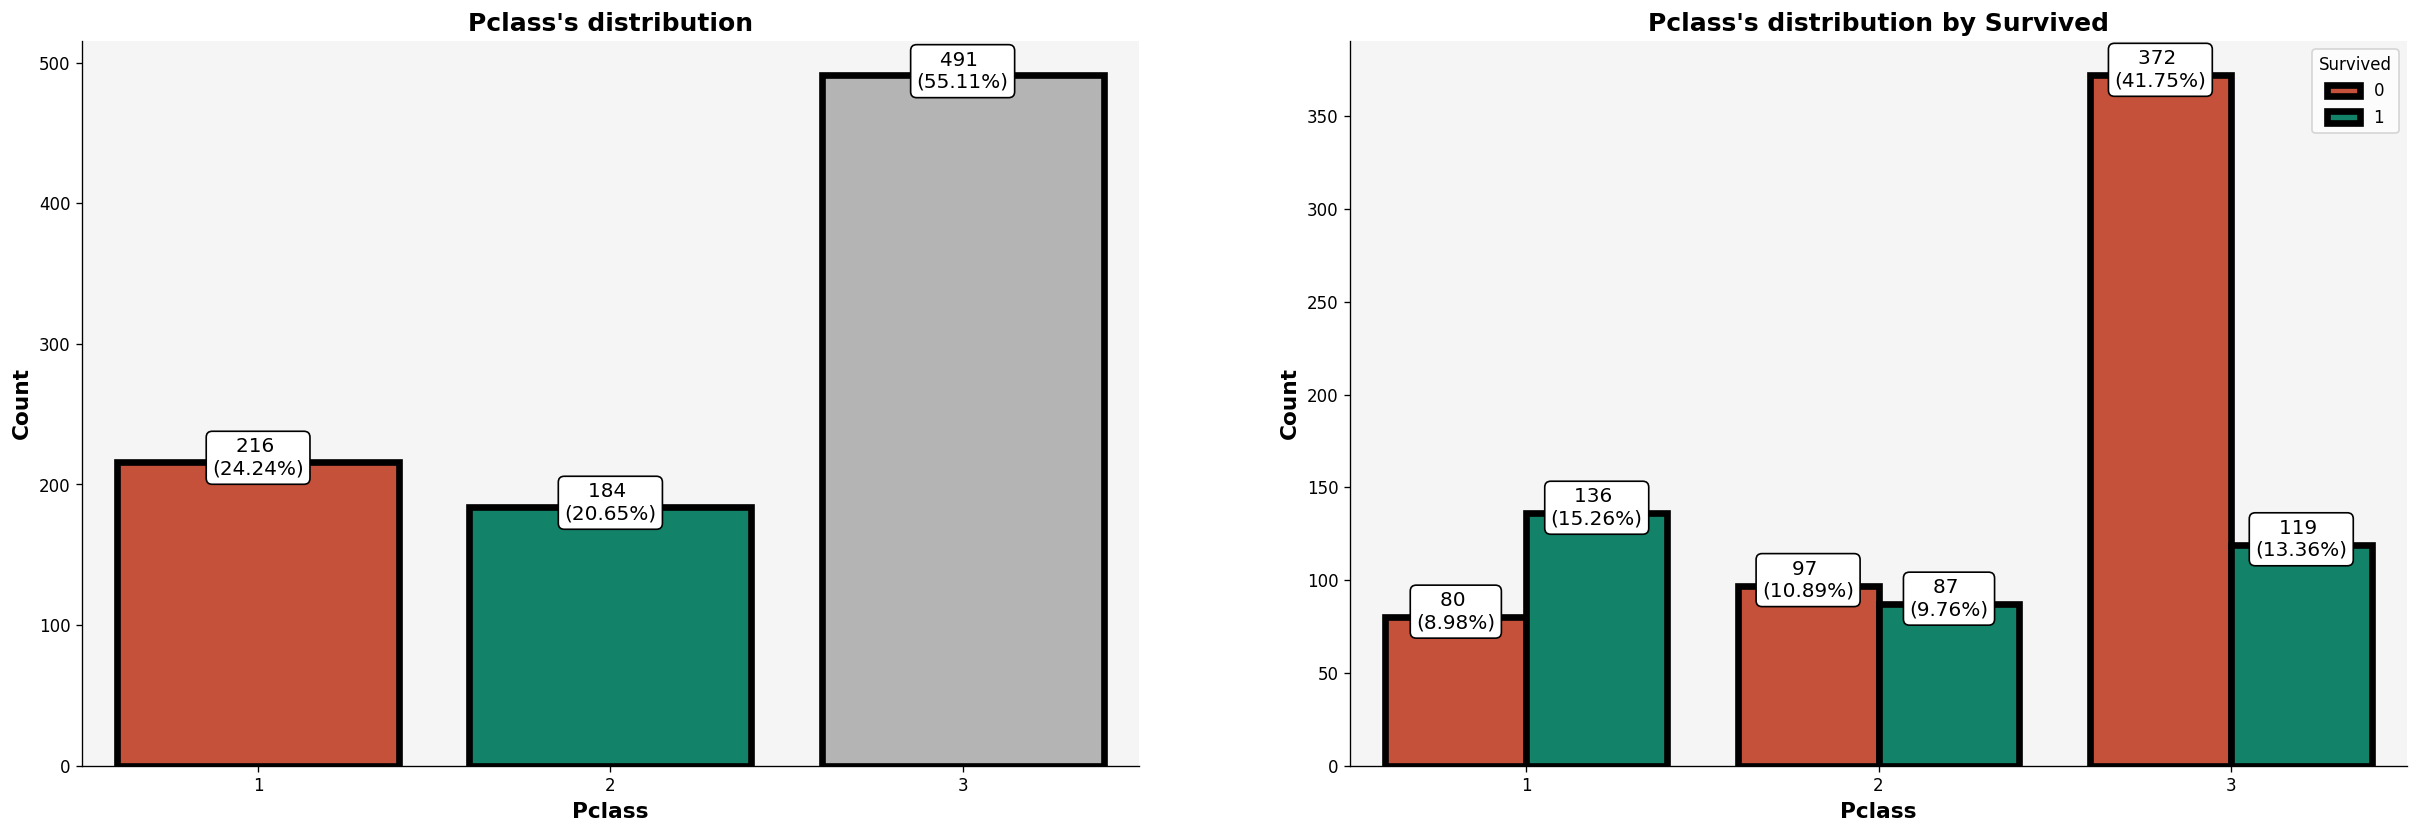

,count,sum,mean
,Survived,Survived,Survived
Pclass,,,
1,216,136,0.629630
2,184,87,0.472826
3,491,119,0.242363


In [16]:
cat_dist(train, var='Pclass', hue='Survived')
train.pivot_table(index="Pclass", values="Survived", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

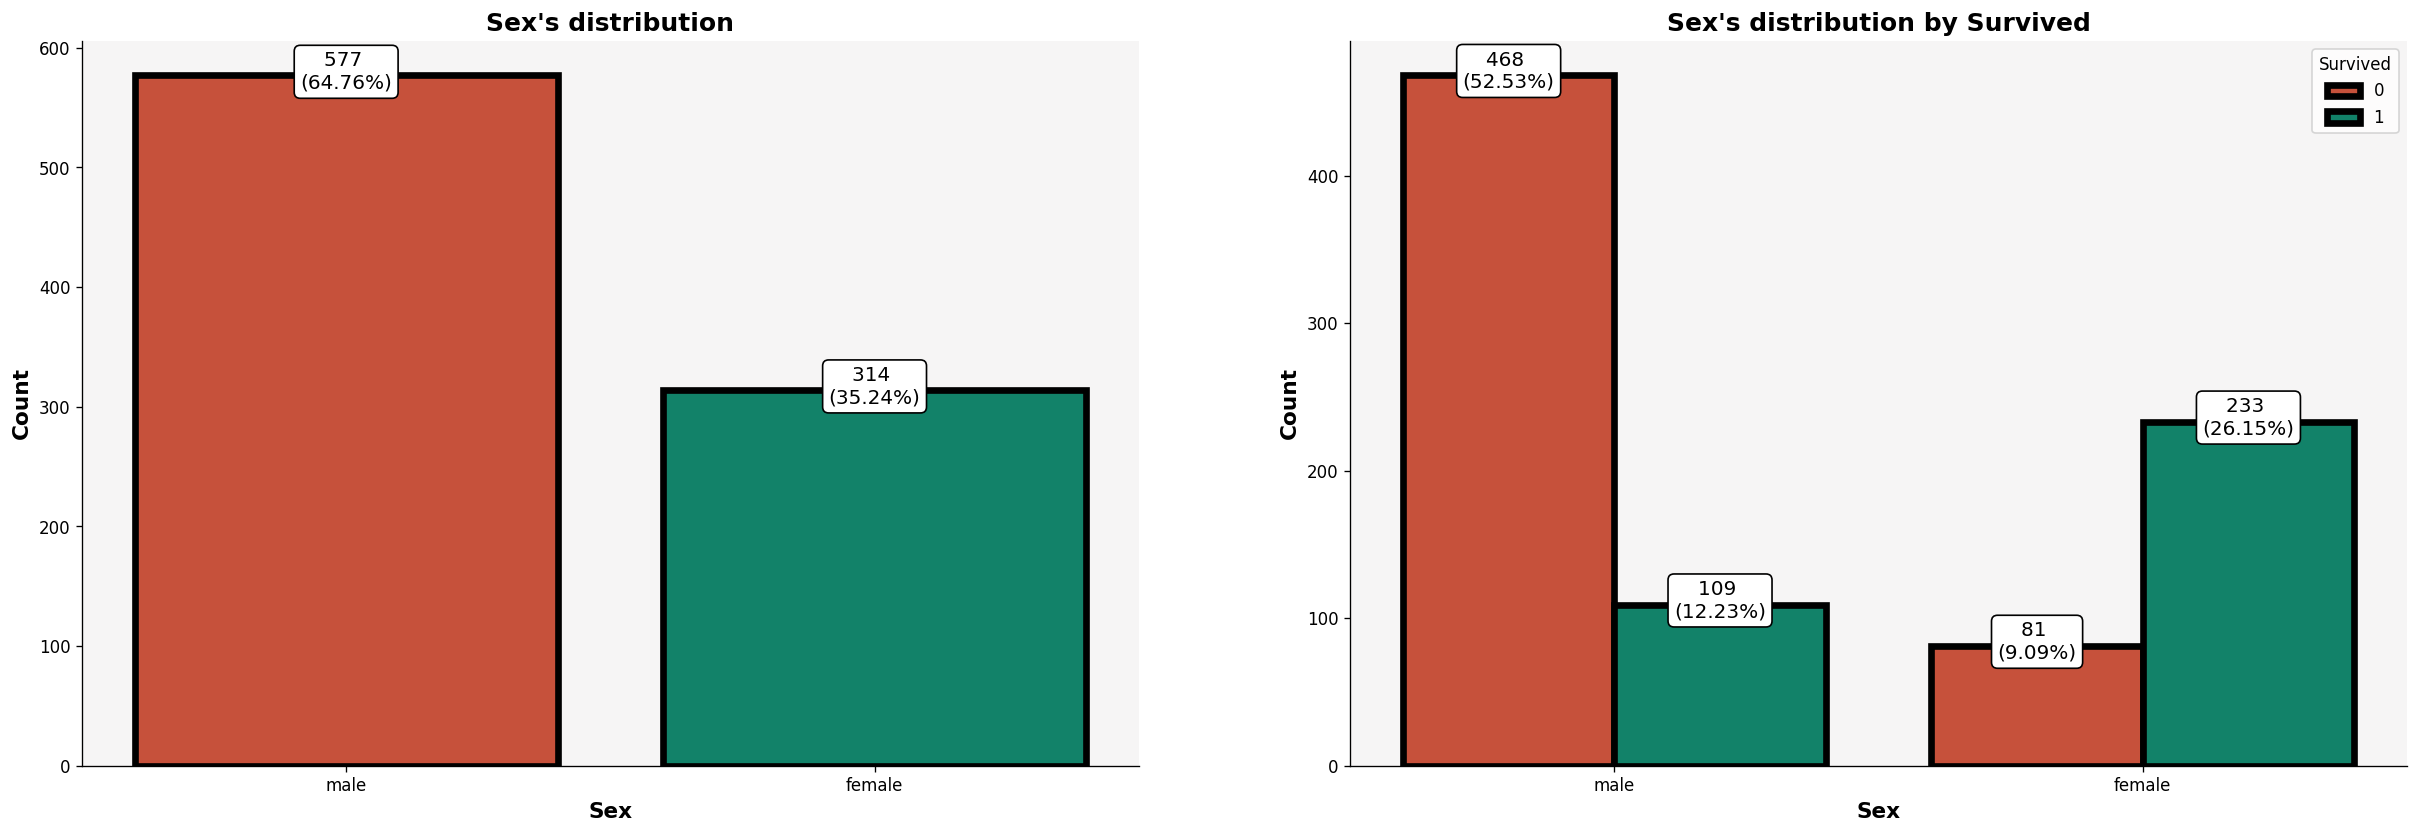

,count,sum,mean
,Survived,Survived,Survived
Sex,,,
female,314,233,0.742038
male,577,109,0.188908


In [17]:
cat_dist(train, var='Sex', hue='Survived')
train.pivot_table(index='Sex', values='Survived', aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

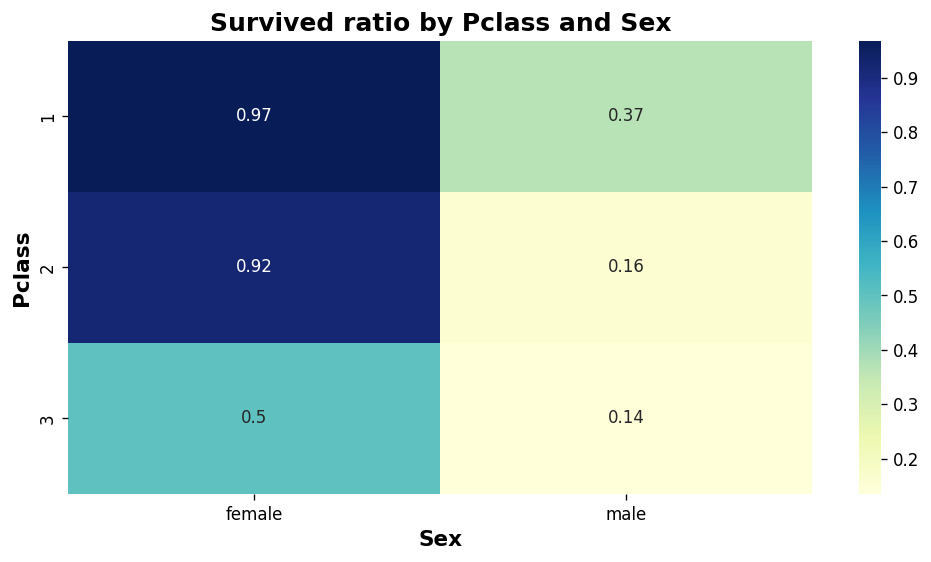

In [18]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='Pclass', columns='Sex', values='Survived'), annot=True, cmap="YlGnBu")
g.set_title('Survived ratio by Pclass and Sex', weight='bold', size=15)
g.set_xlabel('Sex', weight='bold', size=13)
g.set_ylabel('Pclass', weight='bold', size=13)
plt.show()

pd.crosstab([train.Sex, train.Survived], train.Pclass,margins=True).style.background_gradient()

In [19]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 3, figsize=(35, 10))
    sns.violinplot(x=data[x], y=data[y], ax=ax[0], edgecolor='black', linewidth=5)
    sns.boxplot(x=data[x], y=data[y], ax=ax[1])
    sns.stripplot(x=data[x], y=data[y], ax=ax[2])
    for i in range(3):
        ax[i].spines[['top','right']].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

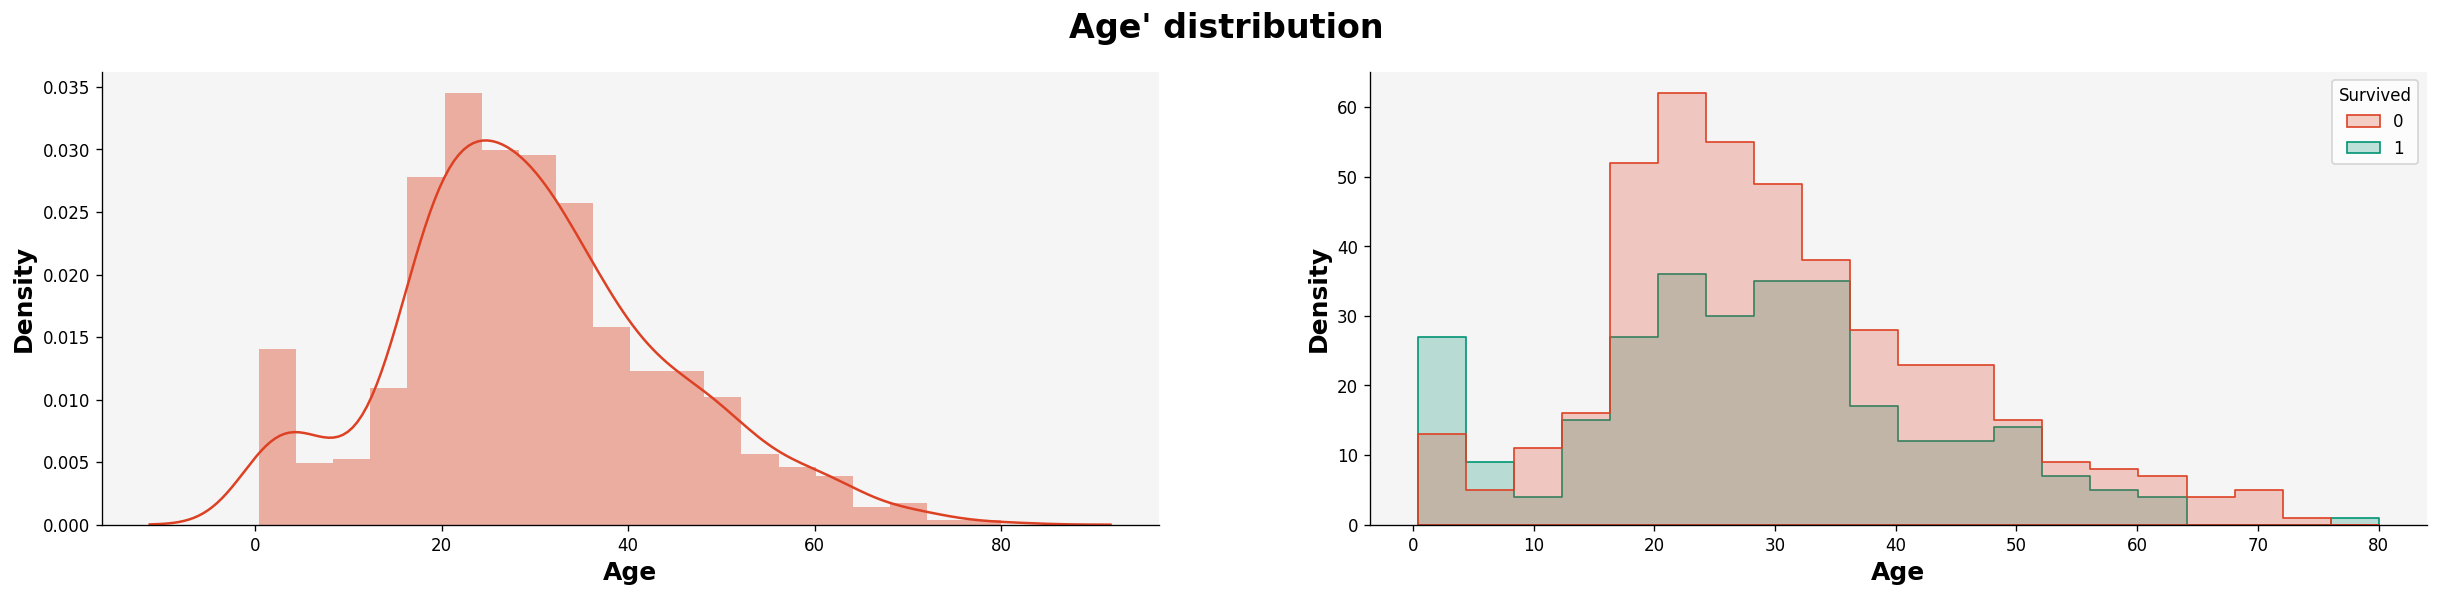

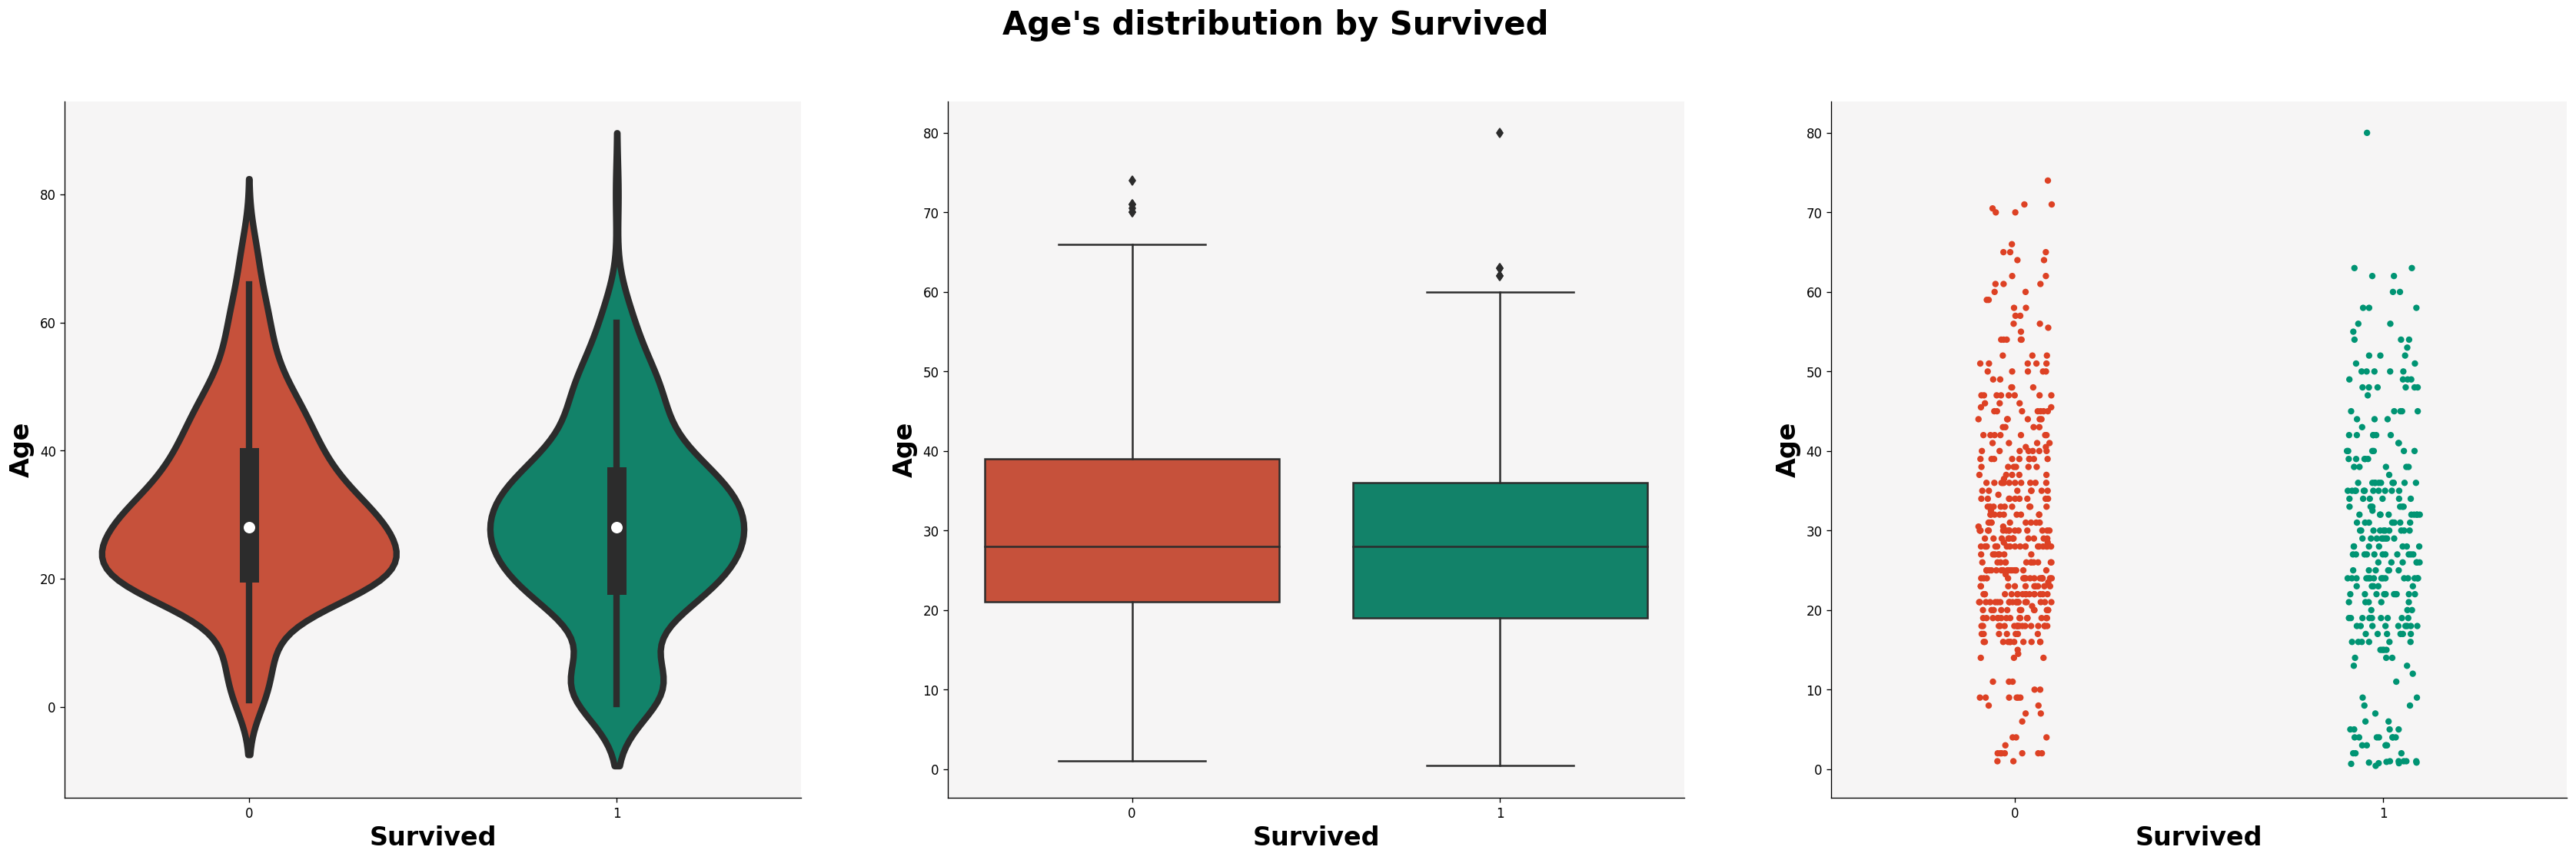

In [20]:
f, ax = plt.subplots(1, 2, figsize=(25, 5))
sns.distplot(train.Age, ax=ax[0])
# sns.distplot(train.loc[train.Survived == 0, 'Age'], ax=ax[1])
# sns.distplot(train.loc[train.Survived == 1, 'Age'], ax=ax[1])
sns.histplot(data=train, x='Age', hue='Survived', ax=ax[1], element='step')

for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel('Age', weight='bold', size=15)
    ax[i].set_ylabel('Density', weight='bold', size=15)
    ax[i].set_facecolor(BACKCOLOR)
f.suptitle("Age' distribution", weight='bold', size=20)
plt.show()

continuous_dist(train, x='Survived', y='Age')

In [21]:
import copy

tmp_train = copy.deepcopy(train)
tmp_train['AgeBin'] = 6
for i in range(6):
    tmp_train.loc[(tmp_train.Age >= 10*i) & (tmp_train.Age < 10*(i + 1)), 'AgeBin'] = i
tmp_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2


In [22]:
t0 = pd.pivot_table(index='AgeBin', values='Survived', data=tmp_train).style.background_gradient()
t1 = pd.pivot_table(index='Pclass', columns='AgeBin', values='Survived', data=tmp_train).style.background_gradient()
t2 = pd.crosstab([tmp_train.AgeBin, tmp_train.Pclass], [tmp_train.Sex, tmp_train.Survived],margins=True).style.background_gradient(vmax=100)
t3 = pd.pivot_table(index='Sex', columns='AgeBin', values='Survived', data=tmp_train).style.background_gradient()
multi_table([t2, t0, t1, t3])

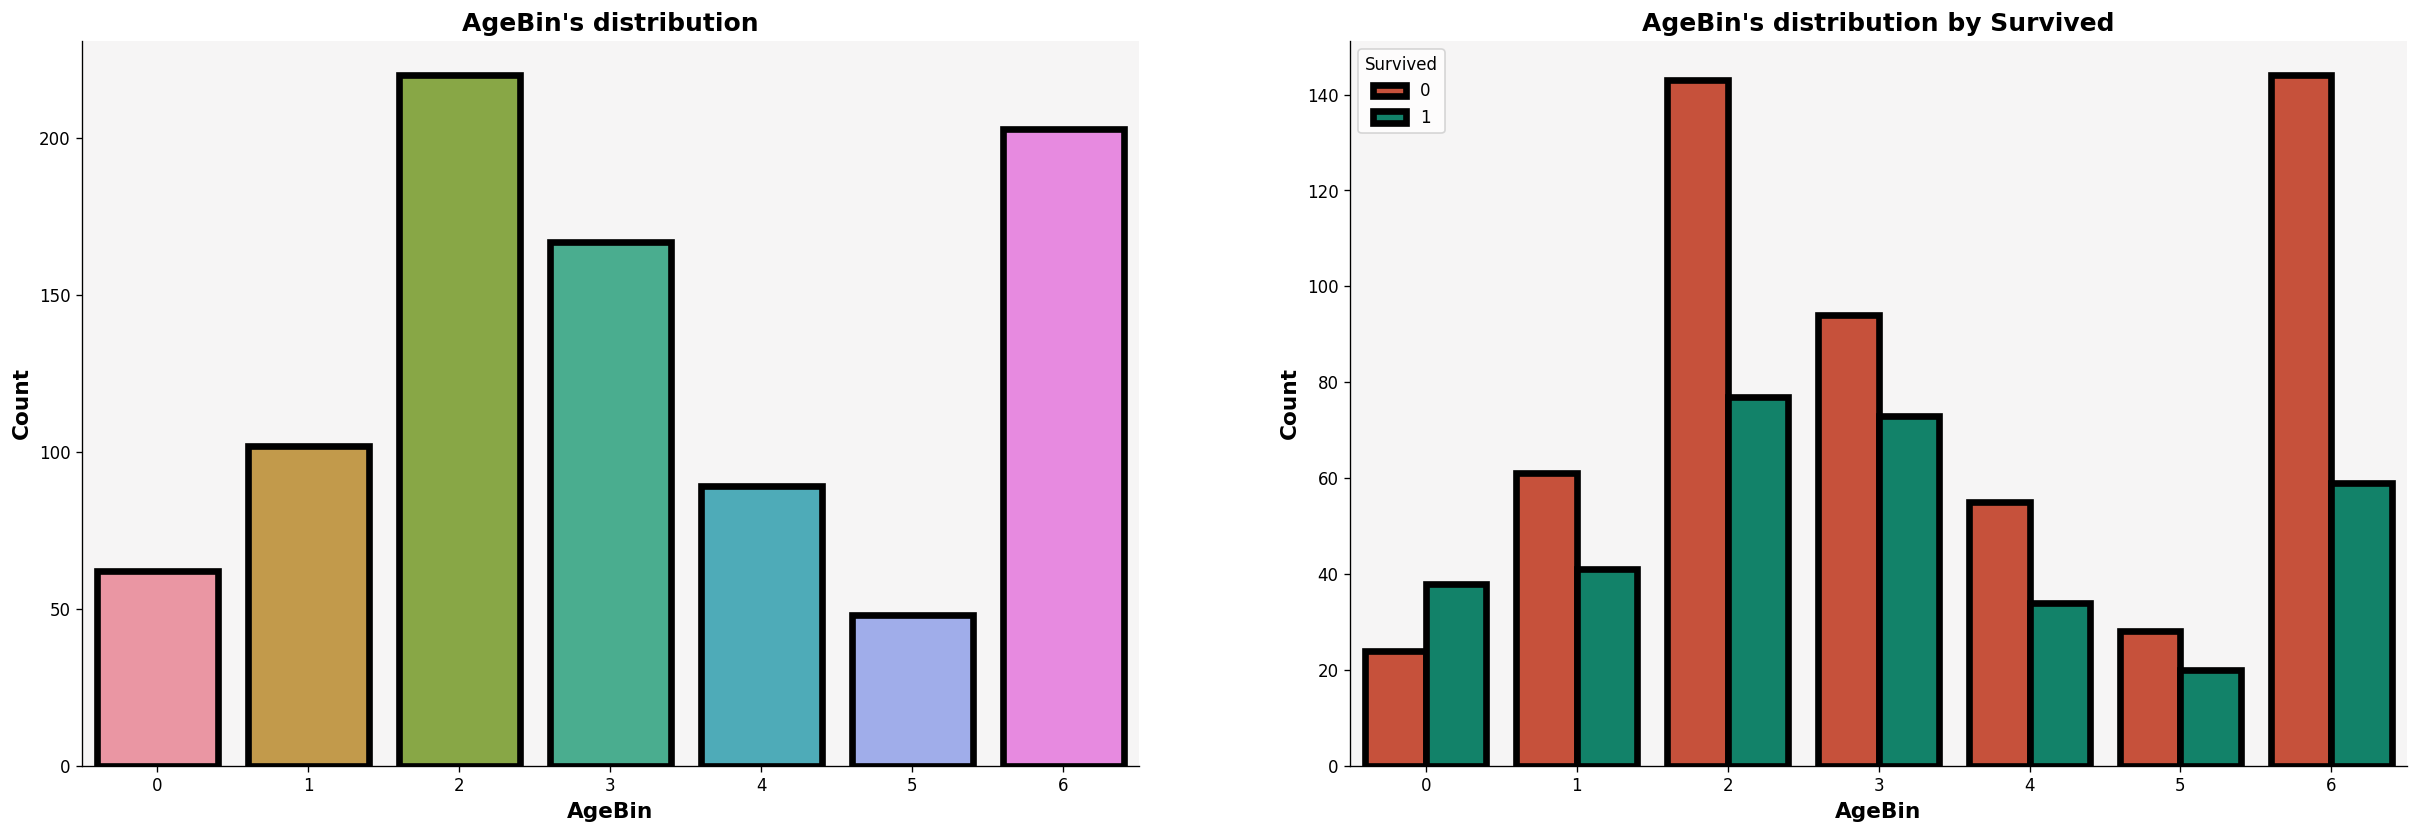

In [23]:
cat_dist(tmp_train, var='AgeBin', hue='Survived', msg_show=False)

In [24]:
all_data.corr().Age

PassengerId    0.028814
Survived      -0.077221
Pclass        -0.408106
Age            1.000000
SibSp         -0.243699
Parch         -0.150917
Fare           0.178740
Name: Age, dtype: float64

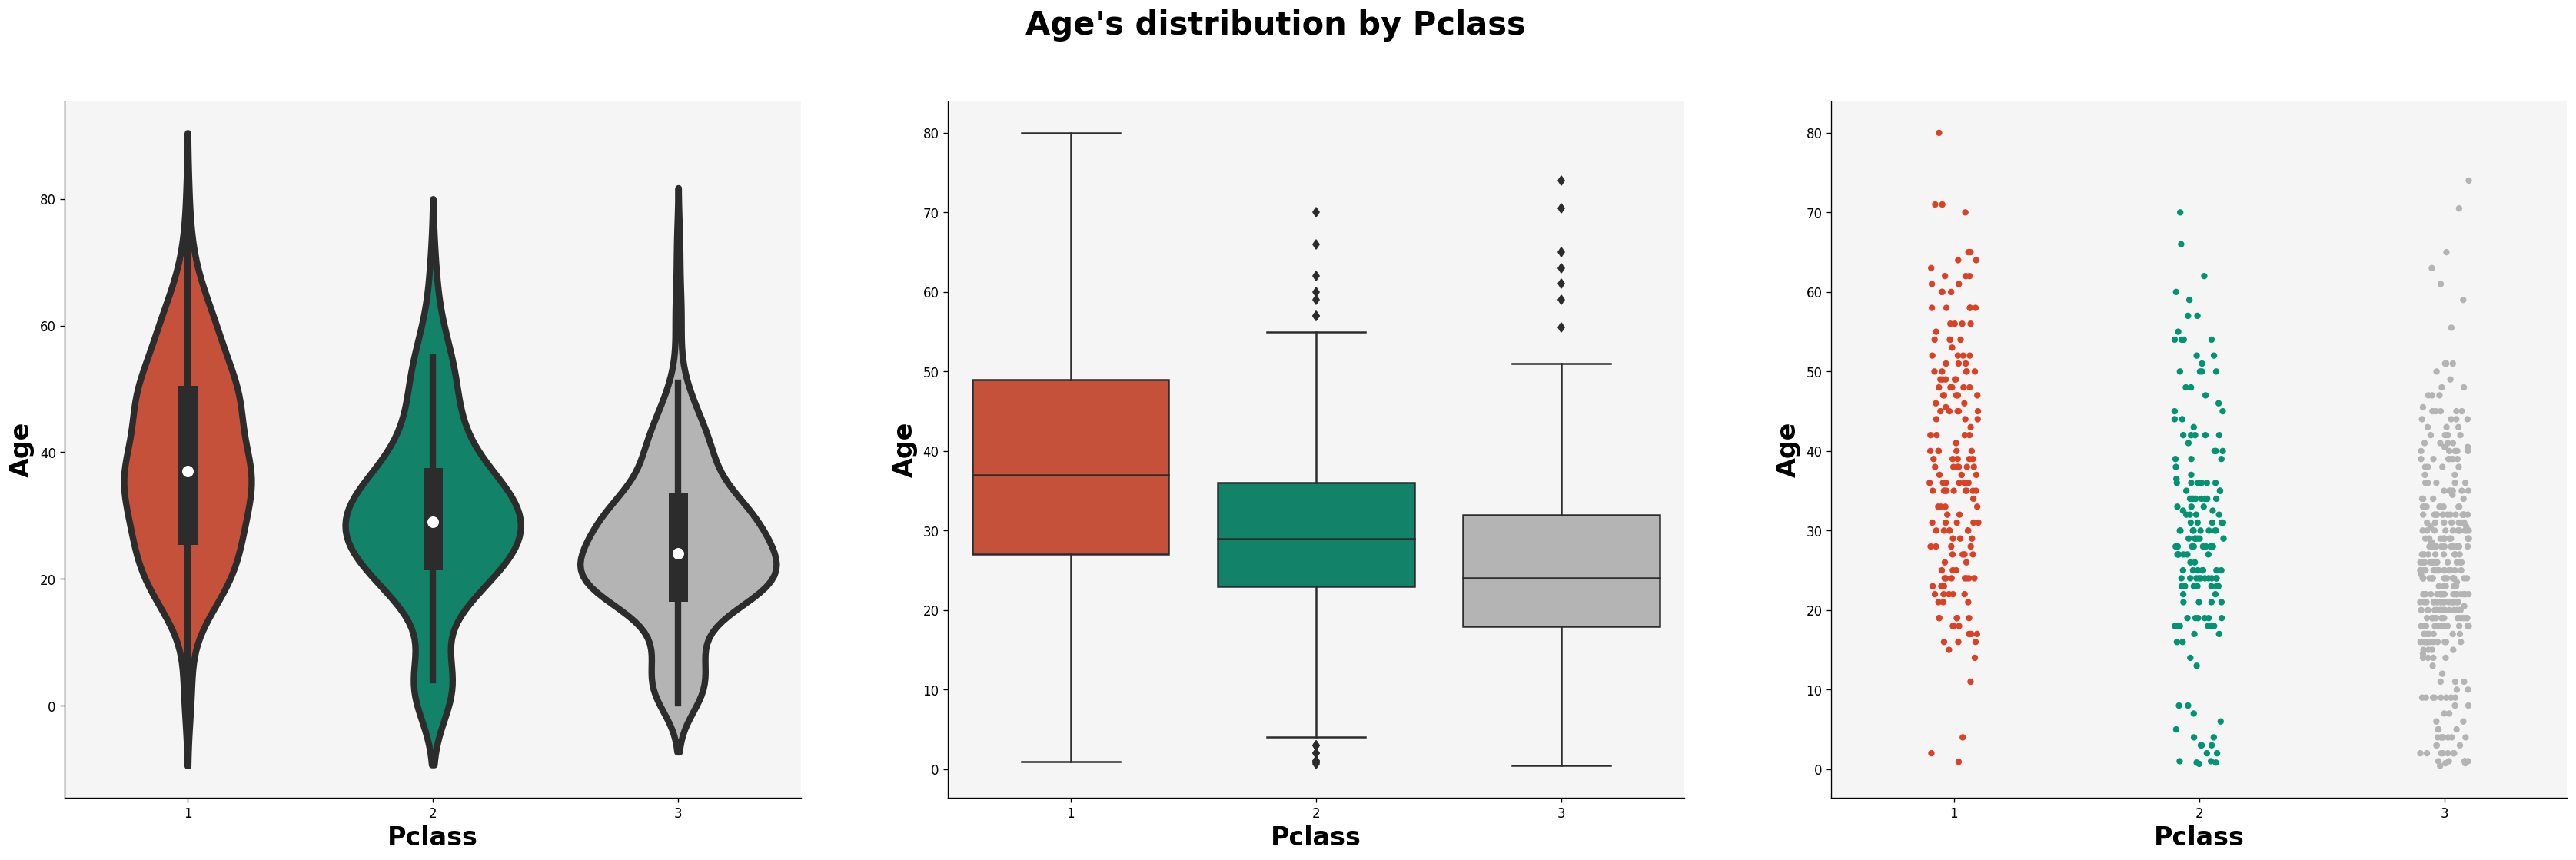

In [25]:
continuous_dist(train, x='Pclass', y='Age')

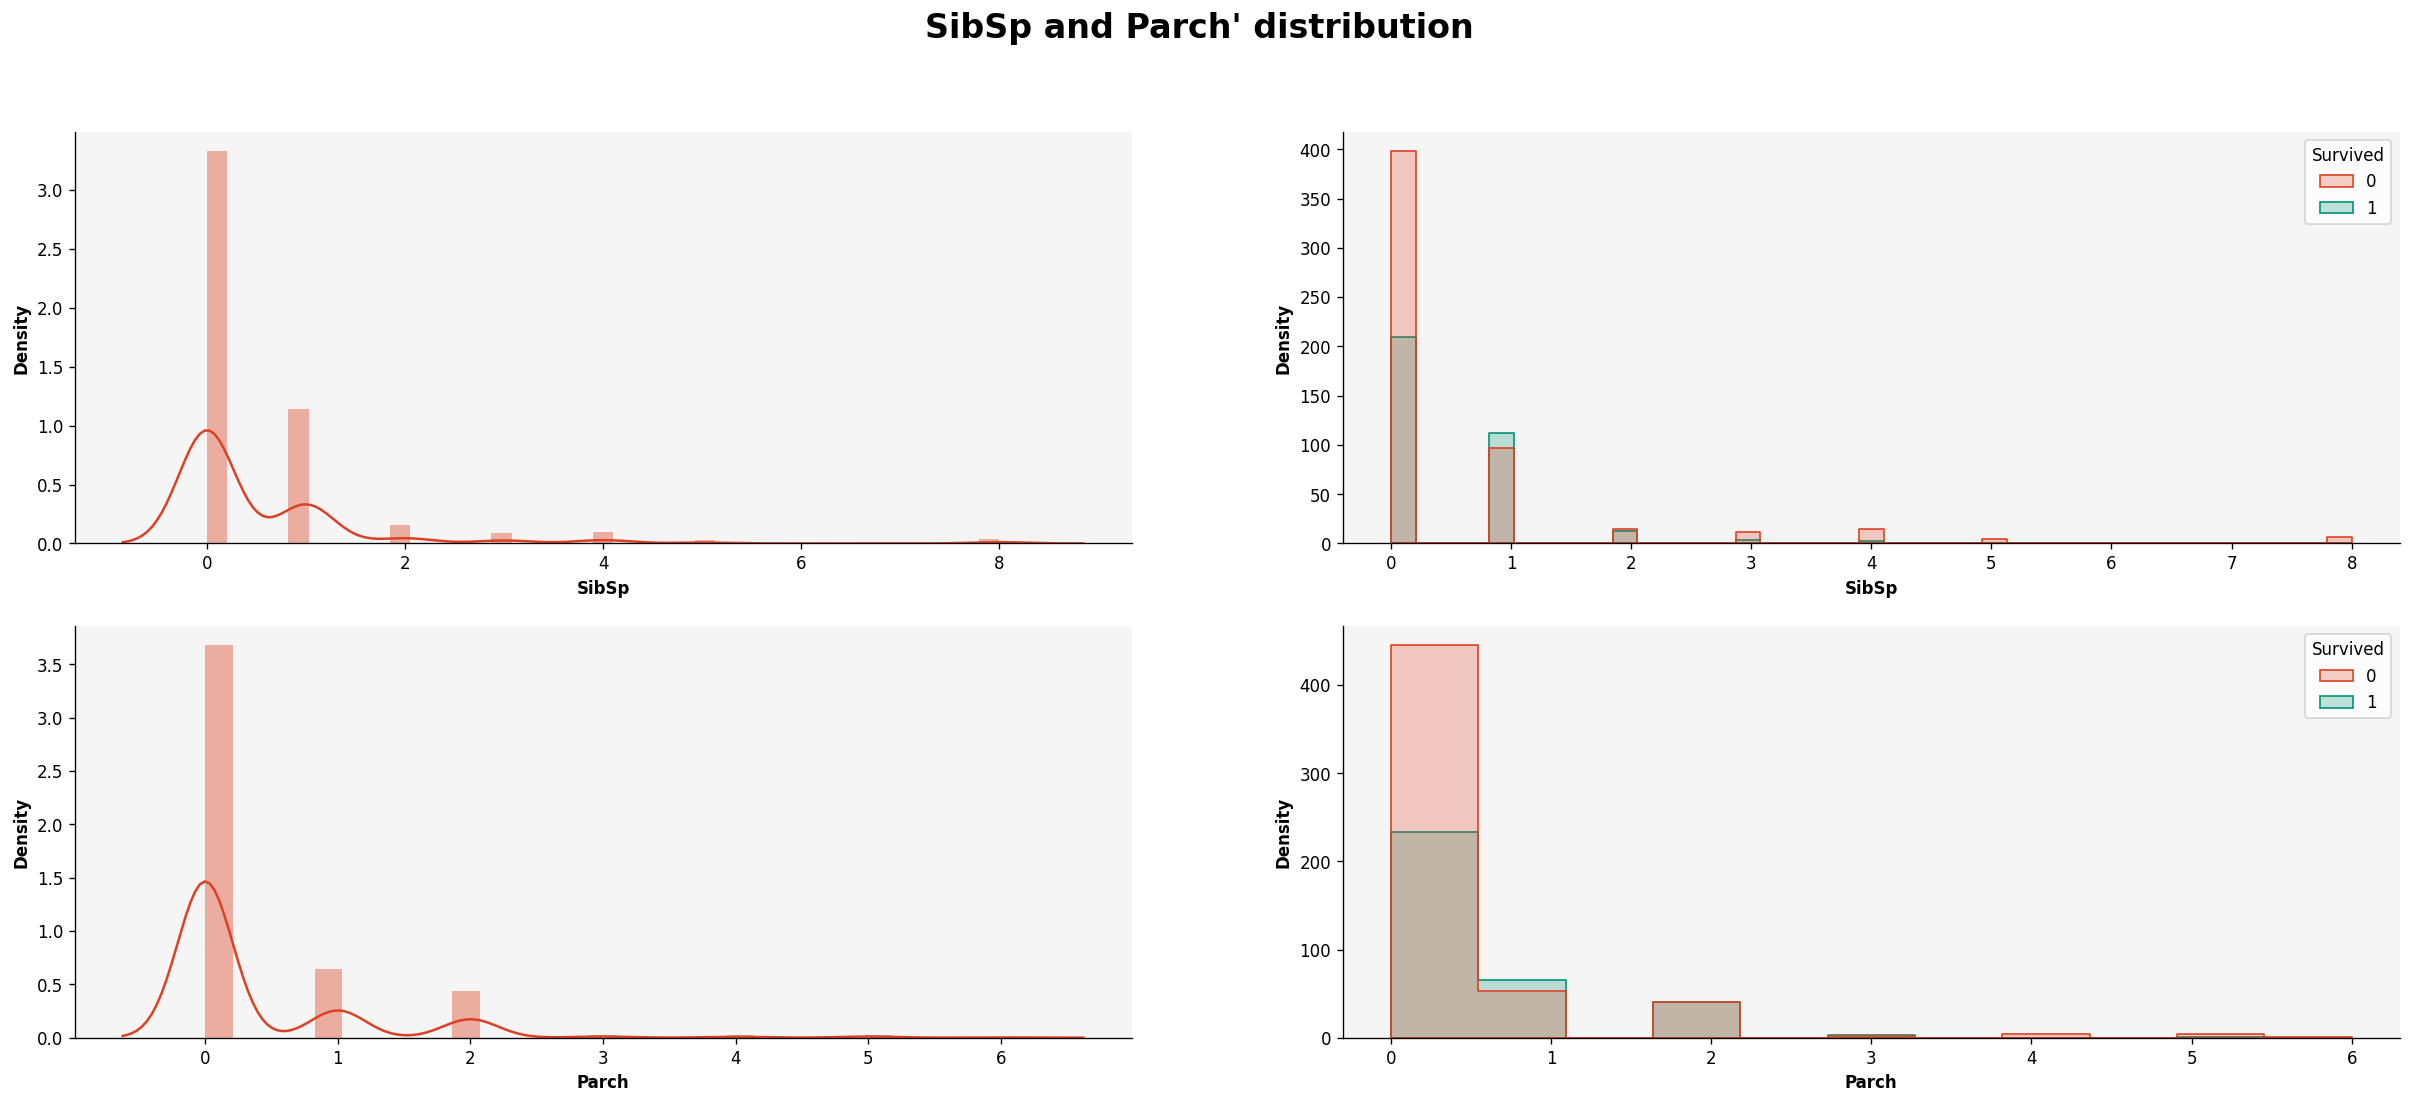

In [26]:
f, ax = plt.subplots(2, 2, figsize=(25, 10))
sns.distplot(train.SibSp, ax=ax[0][0])
sns.histplot(data=train, x='SibSp', hue='Survived', ax=ax[0][1], element='step')

sns.distplot(train.Parch, ax=ax[1][0])
sns.histplot(data=train, x='Parch', hue='Survived', ax=ax[1][1], element='step')

for i in range(4):
    ax[i//2][i%2].spines[['top','right']].set_visible(False)
    if i < 2:
        ax[i//2][i%2].set_xlabel('SibSp', weight='bold', size=10)
    else:
        ax[i//2][i%2].set_xlabel('Parch', weight='bold', size=10)
    ax[i//2][i%2].set_ylabel('Density', weight='bold', size=10)
    ax[i//2][i%2].set_facecolor(BACKCOLOR)
f.suptitle("SibSp and Parch' distribution", weight='bold', size=20)
plt.show()

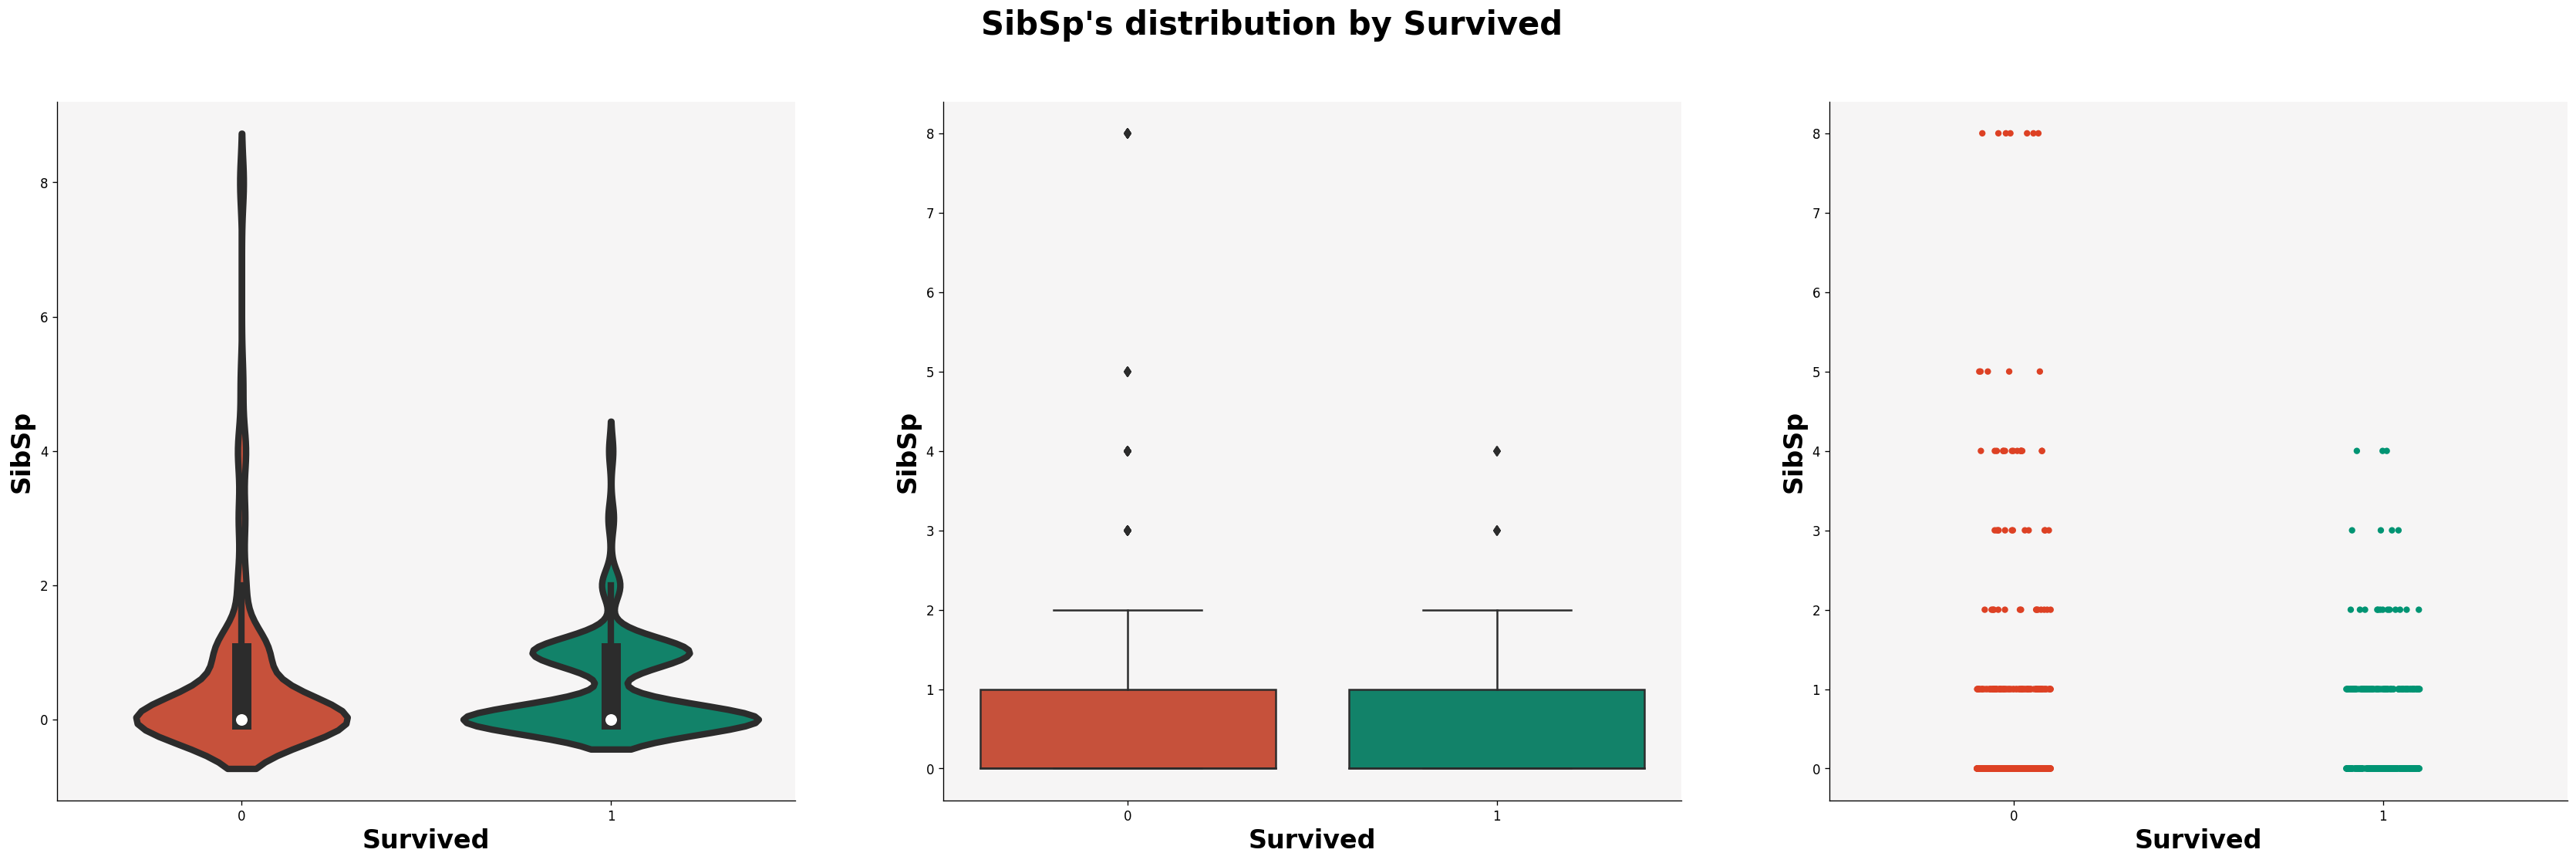

In [27]:
continuous_dist(train, x='Survived', y='SibSp')

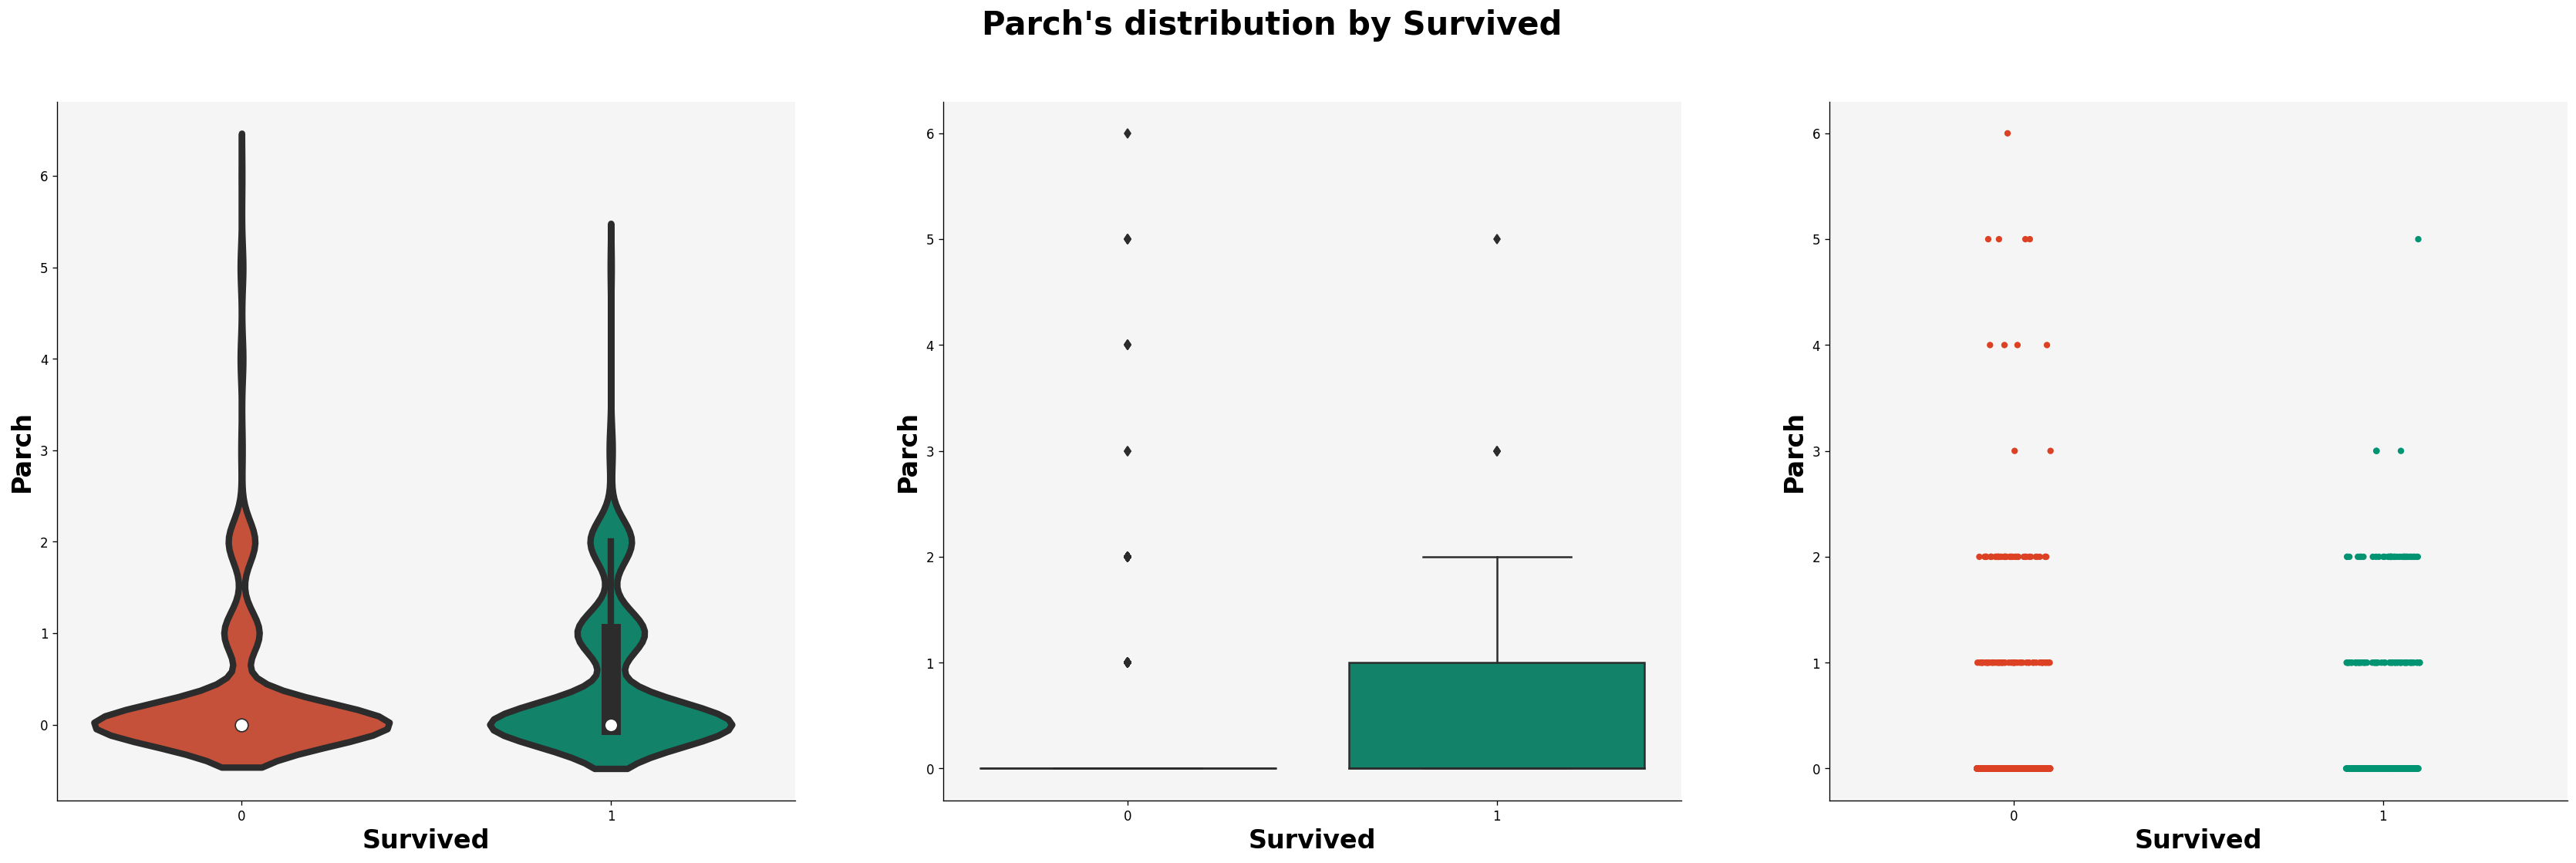

In [28]:
continuous_dist(train, x='Survived', y='Parch')

In [29]:
t0 = pd.pivot_table(index='SibSp', values='Survived', data=train).style.bar()
t1 = pd.pivot_table(index='Parch', values='Survived', data=train).style.bar()
t2 = pd.pivot_table(index='SibSp', columns='Parch', values='Survived', data=train).style.bar()
multi_table([t0, t1, t2])

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000
,Survived
Parch,


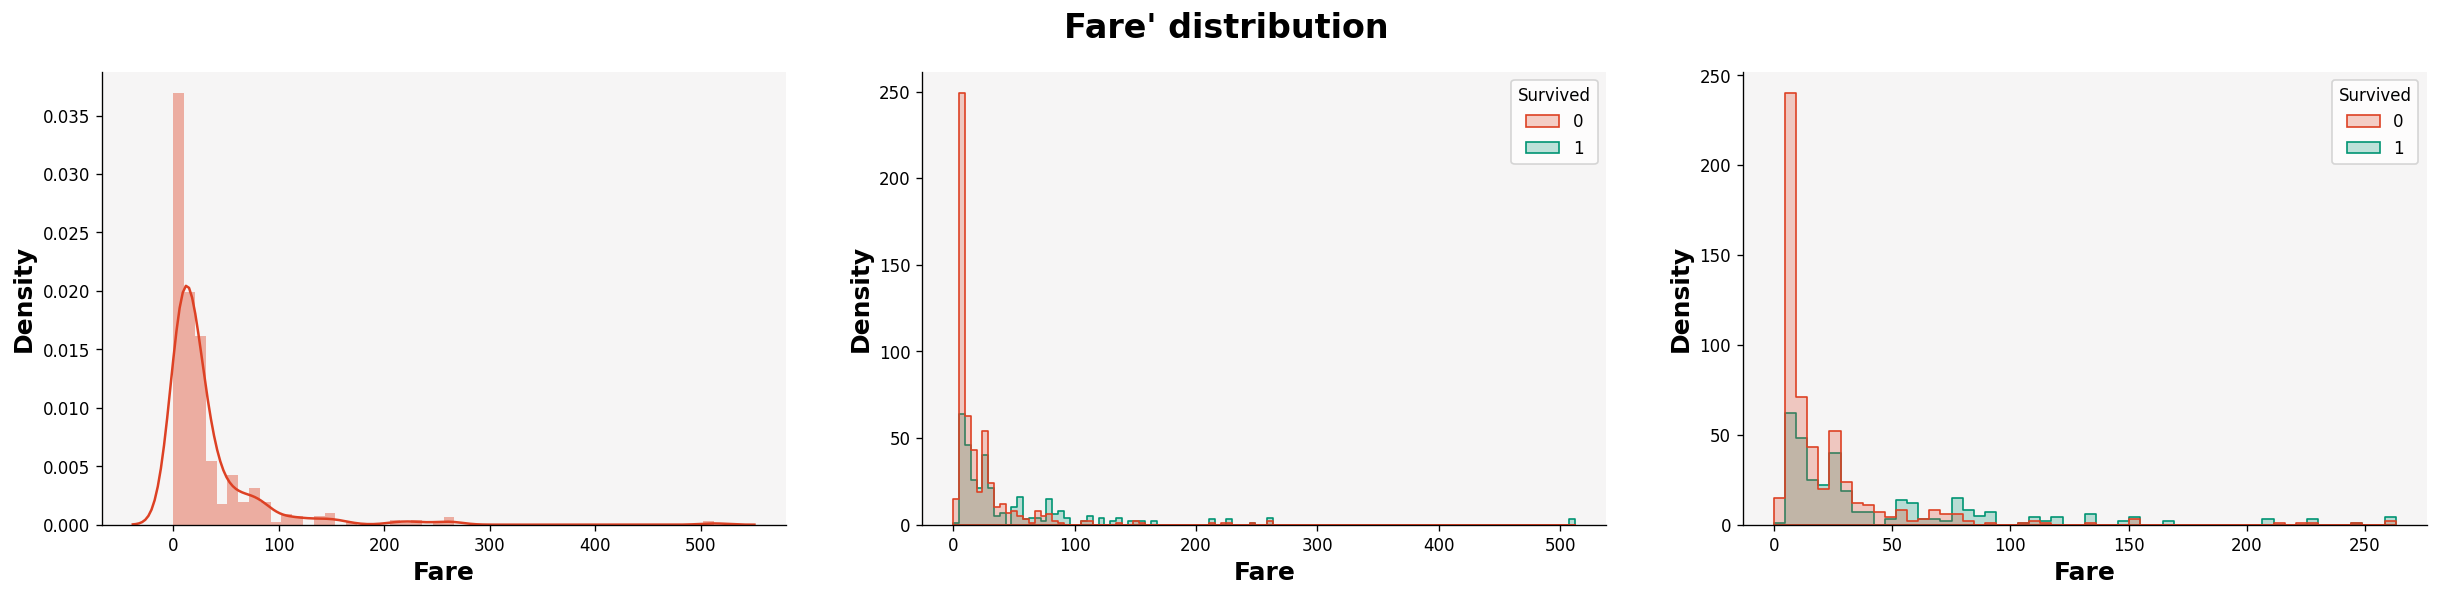

In [30]:
f, ax = plt.subplots(1, 3, figsize=(25, 5))
sns.distplot(train.Fare, ax=ax[0])
sns.histplot(data=train, x='Fare', hue='Survived', ax=ax[1], element='step')
sns.histplot(data=train[train.Fare < 300], x='Fare', hue='Survived', ax=ax[2], element='step')

for i in range(3):
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].set_xlabel('Fare', weight='bold', size=15)
    ax[i].set_ylabel('Density', weight='bold', size=15)
    ax[i].set_facecolor(BACKCOLOR)
f.suptitle("Fare' distribution", weight='bold', size=20)
plt.show()

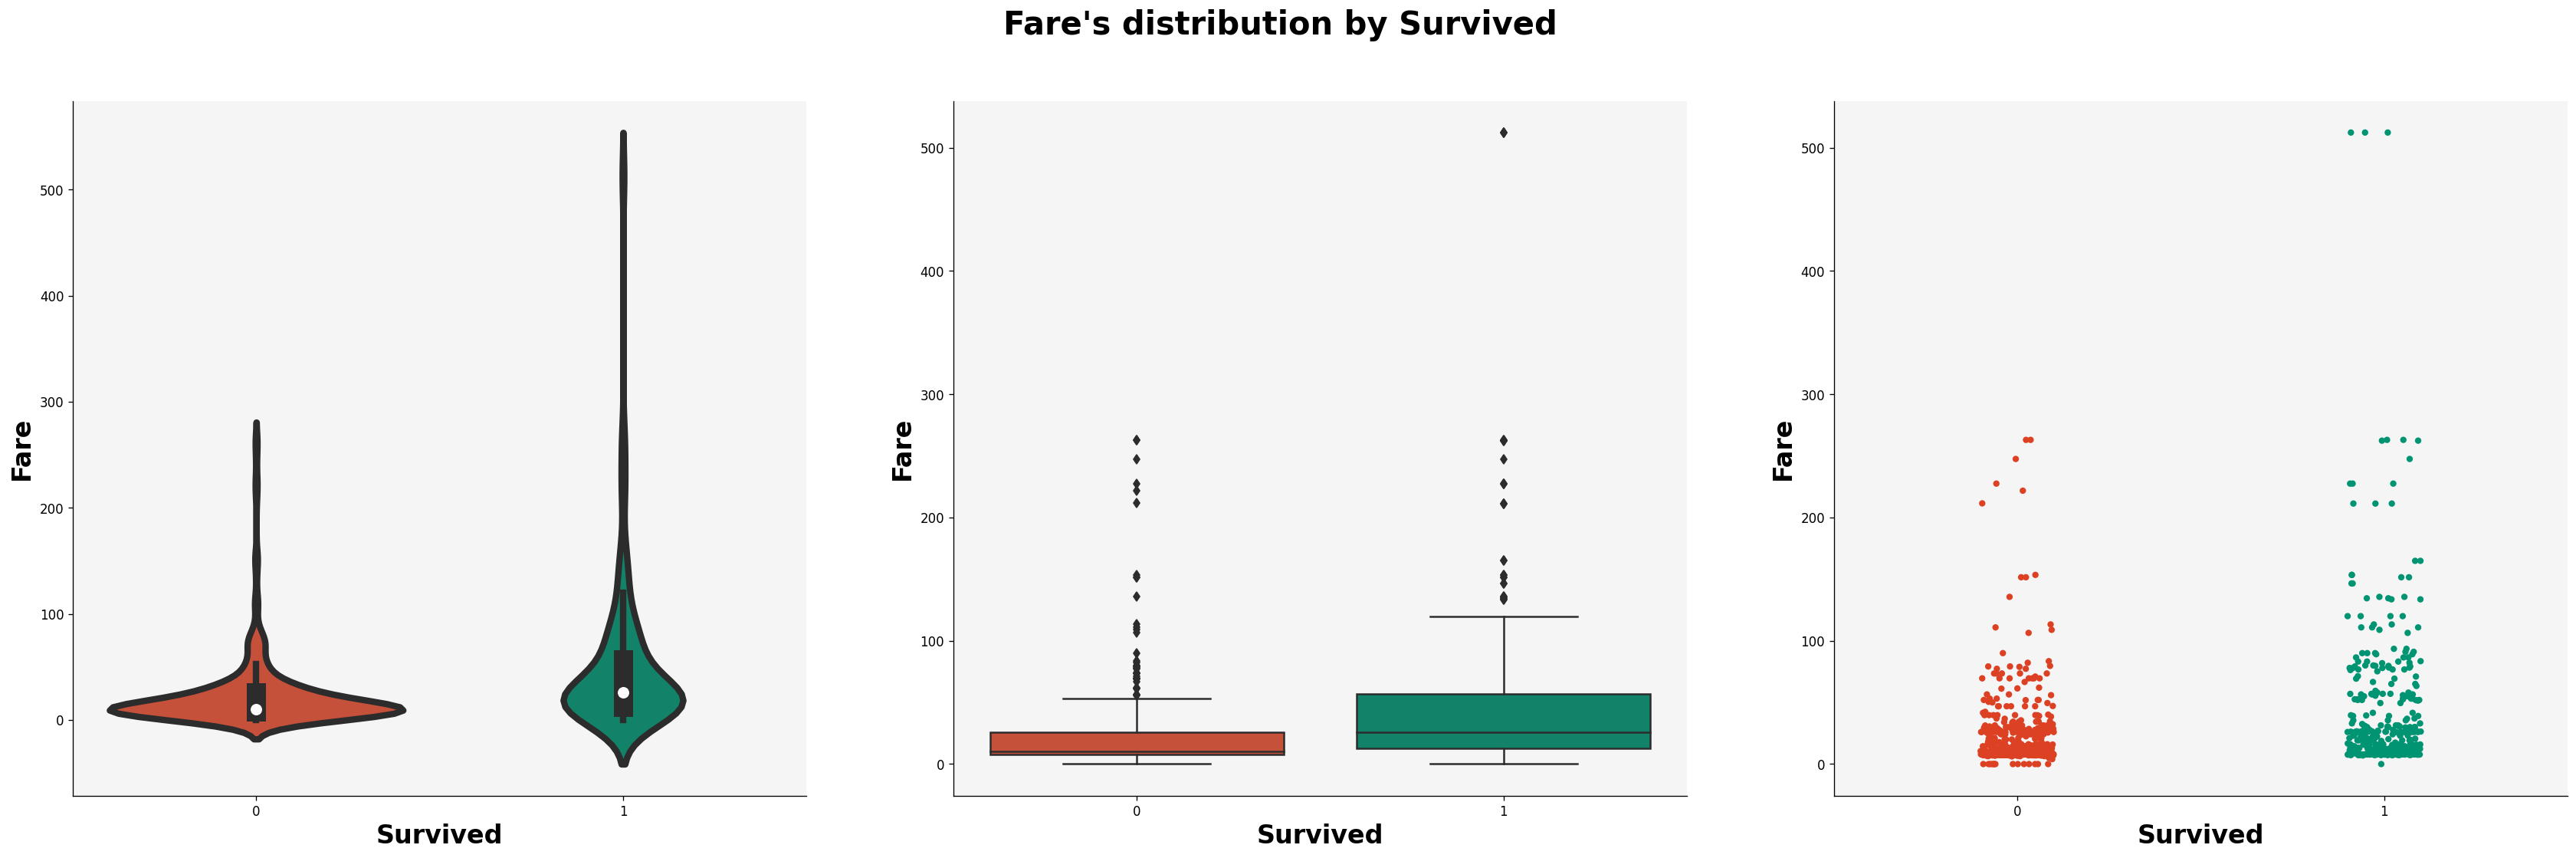

In [31]:
continuous_dist(train, x='Survived', y='Fare')

In [32]:
tmp_train = copy.deepcopy(train)
tmp_train['FareBin'] = pd.cut(tmp_train.Fare, 10)
tmp_train['FareBin'] = LabelEncoder().fit_transform(tmp_train.FareBin)
tmp_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


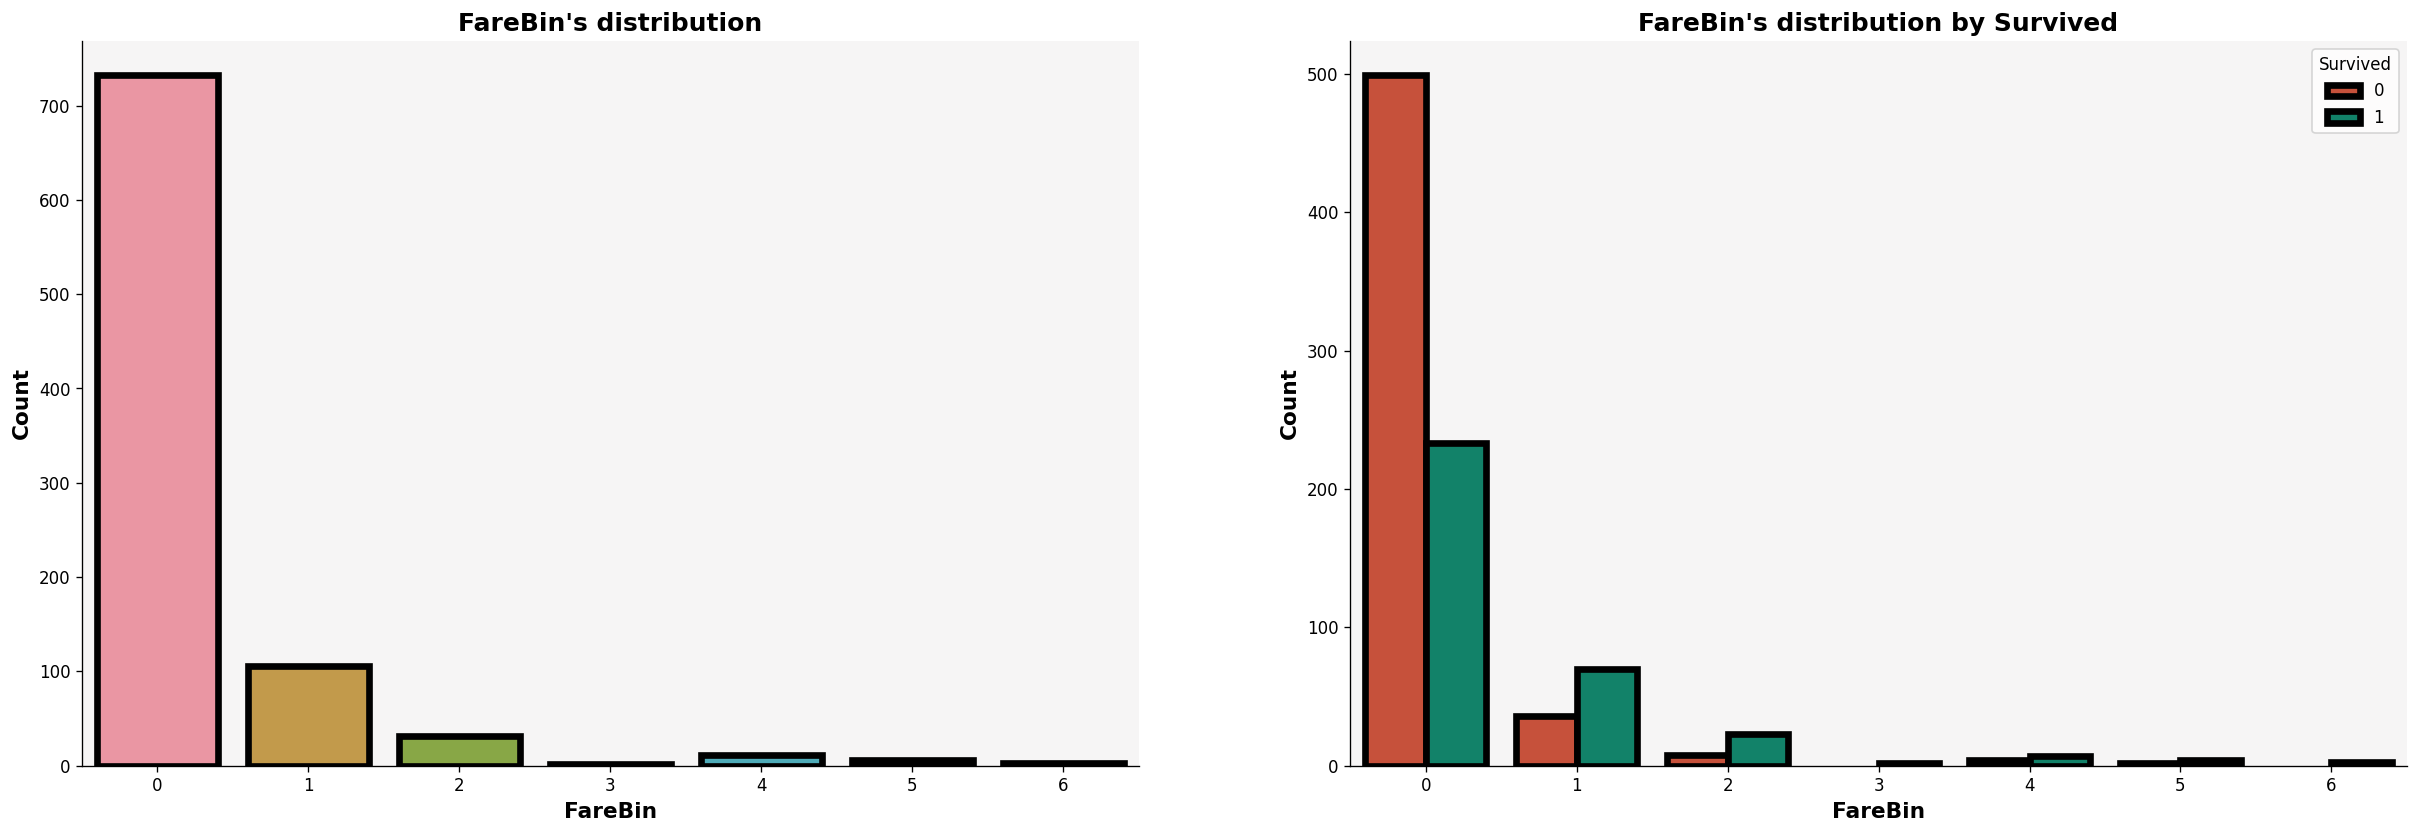

In [33]:
cat_dist(tmp_train, var='FareBin', hue='Survived', msg_show=False)

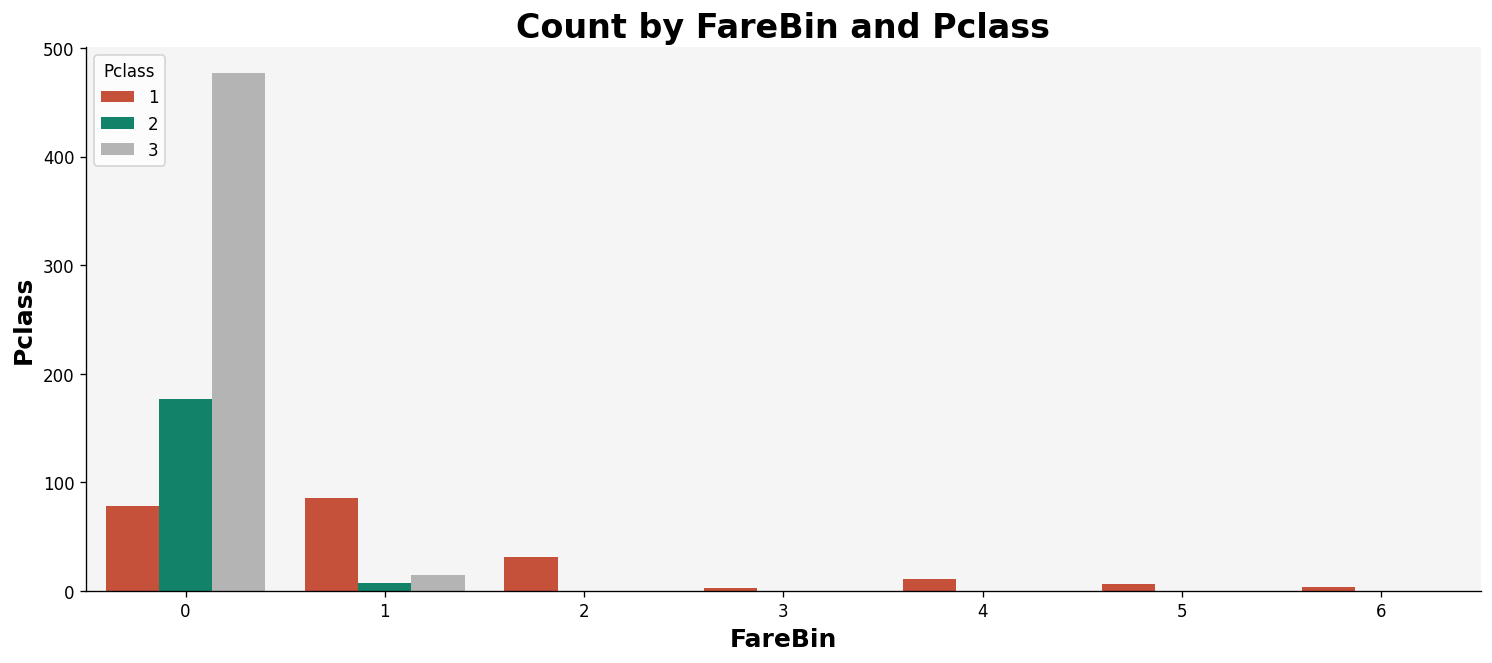

In [34]:
plt.subplots(figsize=(15, 6))
g = sns.countplot('FareBin', hue='Pclass', data=tmp_train)
g.set_title('Count by FareBin and Pclass', weight='bold', size=20)
g.spines[['top','right']].set_visible(False)
g.set_xlabel('FareBin', weight='bold', size=15)
g.set_ylabel('Pclass', weight='bold', size=15)
g.set_facecolor(BACKCOLOR)
plt.show()

In [35]:
pd.pivot_table(index='FareBin', columns='Pclass', values='Survived', data=tmp_train).style.bar()

Pclass,1,2,3
FareBin,,,
0,0.435897,0.480226,0.238994
1,0.741176,0.285714,0.357143
2,0.741935,nan,nan
3,1.000000,nan,nan
4,0.636364,nan,nan
5,0.666667,nan,nan
6,1.000000,nan,nan


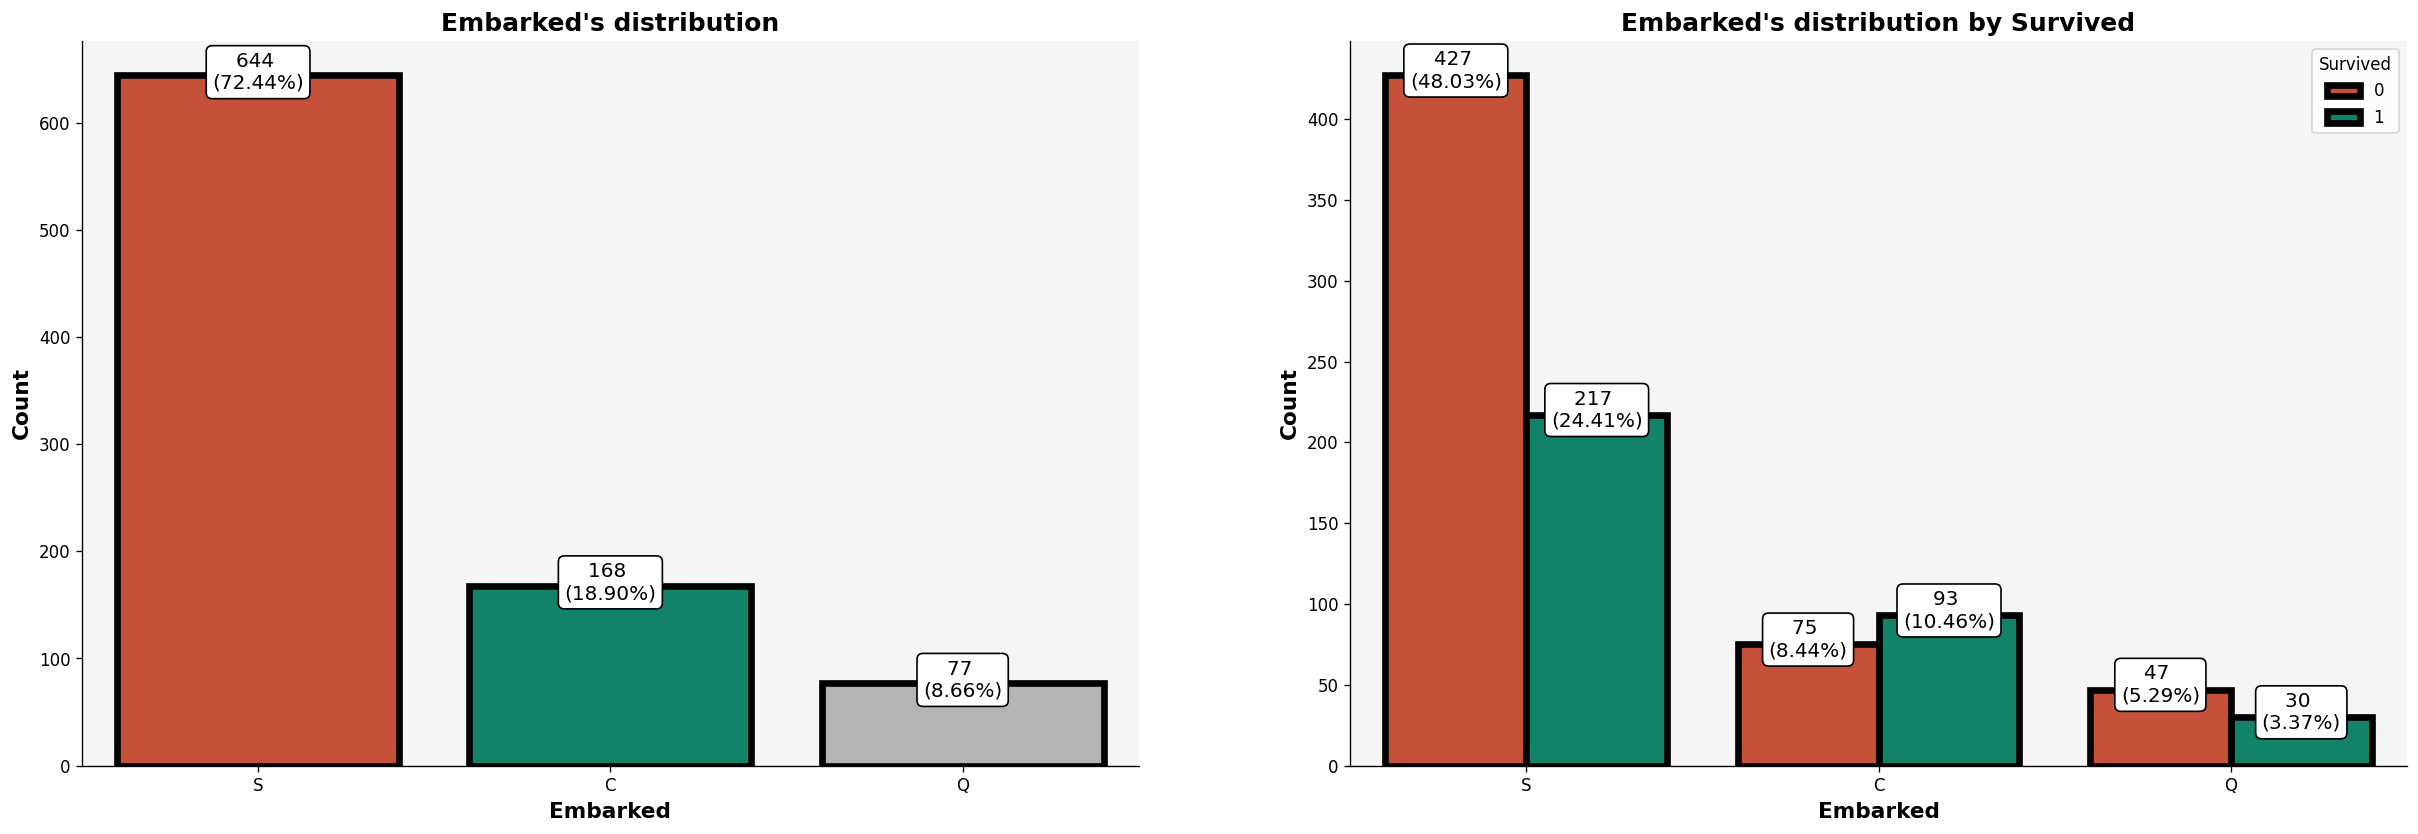

In [36]:
cat_dist(train, var='Embarked', hue='Survived')

In [37]:
pd.pivot_table(data=train, index='Embarked', values='Survived', aggfunc=['count', 'sum', 'mean']).style.background_gradient()

,count,sum,mean
,Survived,Survived,Survived
Embarked,,,
C,168,93,0.553571
Q,77,30,0.389610
S,644,217,0.336957


In [38]:
tmp_all_data = copy.deepcopy(all_data)
t0 = pd.DataFrame(tmp_all_data.Name)
t1 = pd.DataFrame(tmp_all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()).value_counts())
multi_table([t0, t1])

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
1304,"Spector, Mr. Woolf"
1305,"Oliva y Ocana, Dona. Fermina"
1306,"Saether, Mr. Simon Sivertsen"
1307,"Ware, Mr. Frederick"


In [39]:
tmp_all_data['Title'] = tmp_all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#tmp_all_data['Title'] = tmp_all_data.Title.apply(lambda x: 'Others' if x in list(tmp_all_data.Title.value_counts()[tmp_all_data.Title.value_counts() < 8].index) else x)

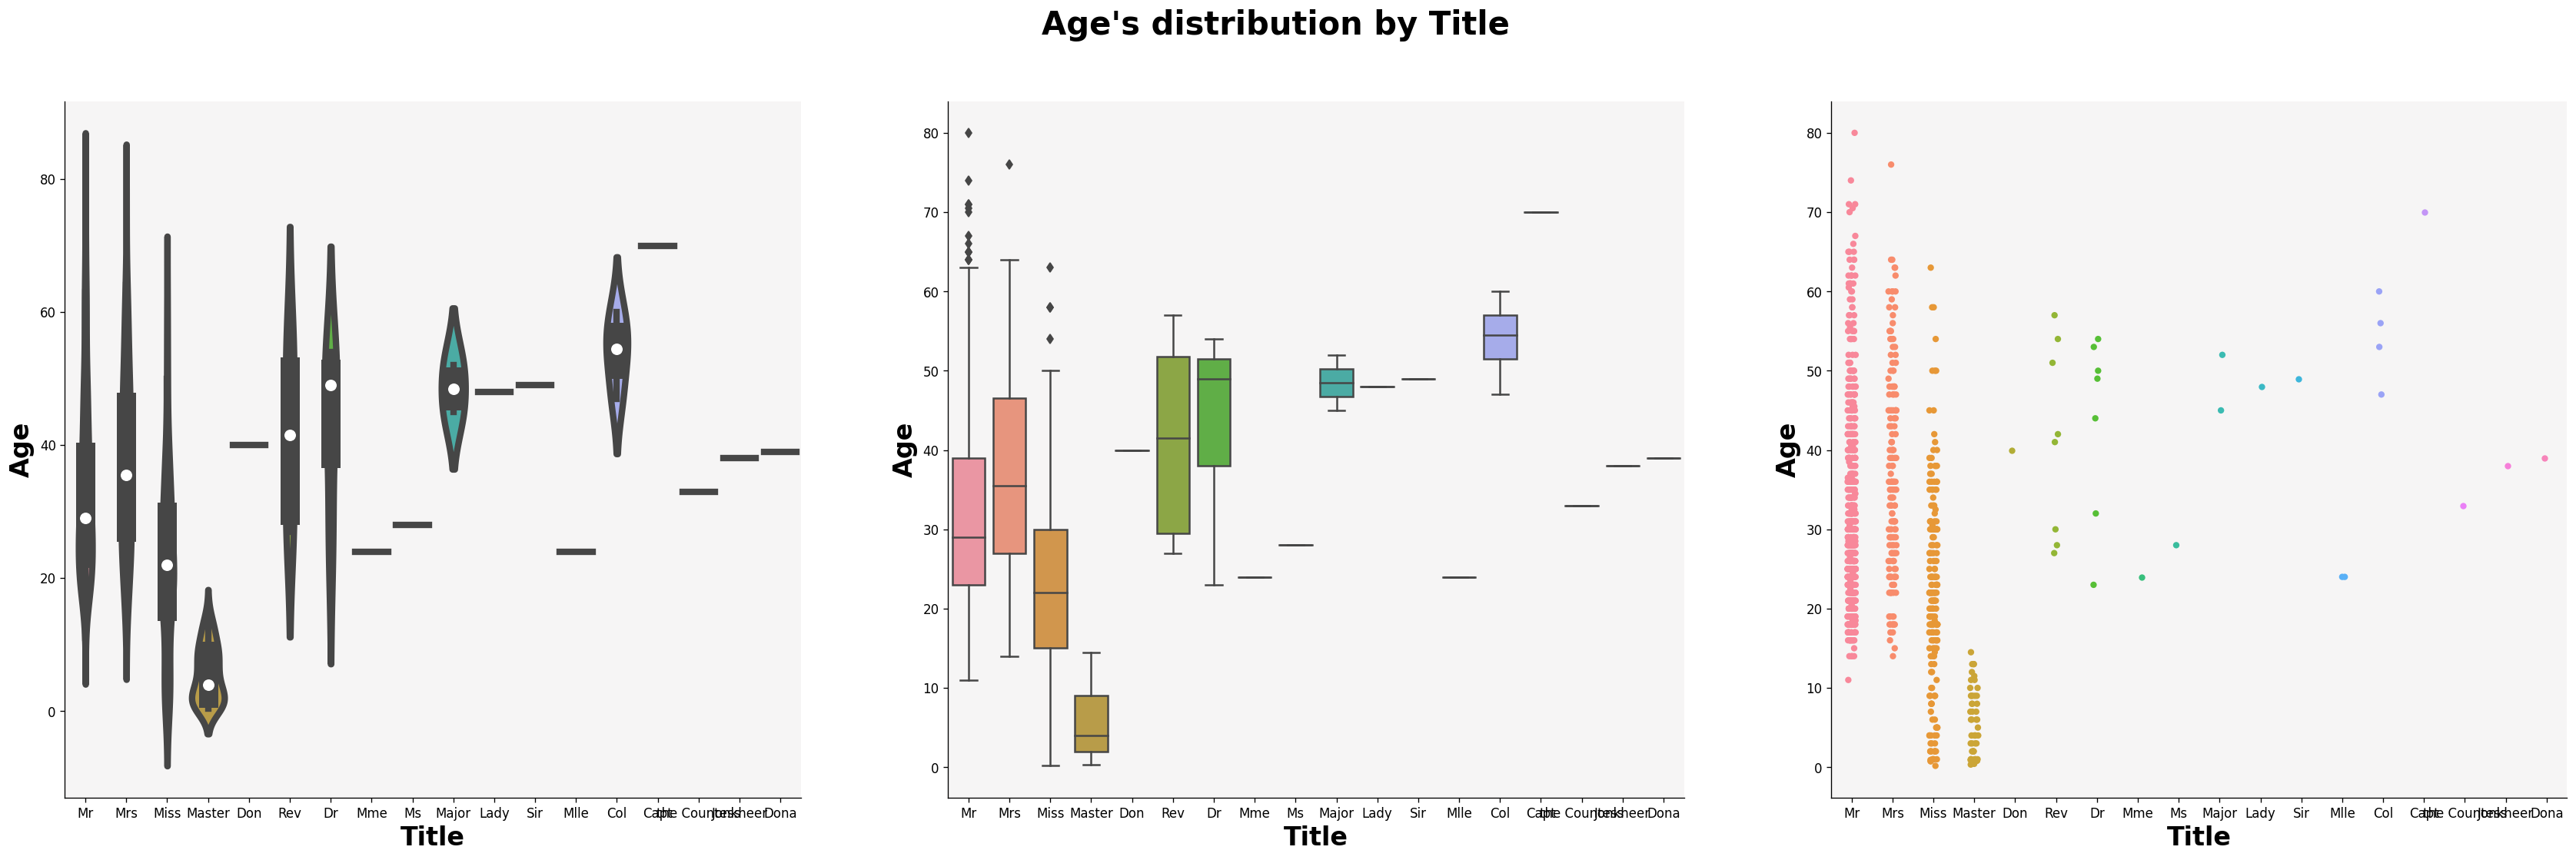

In [40]:
continuous_dist(tmp_all_data, x='Title', y='Age')

In [41]:
tmp_train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [42]:
tmp_train['CabinCnt'] = tmp_train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
tmp_train['CabinClass'] = tmp_train.Cabin.apply(lambda x: str(x)[0])

In [43]:
t0 = pd.DataFrame(tmp_train.CabinCnt.value_counts())
t1 = pd.DataFrame(tmp_train.CabinClass.value_counts())
multi_table([t0, t1])

,CabinCnt
0,687
1,180
2,16
3,6
4,2
,CabinClass
n,687
C,59
B,47
D,33


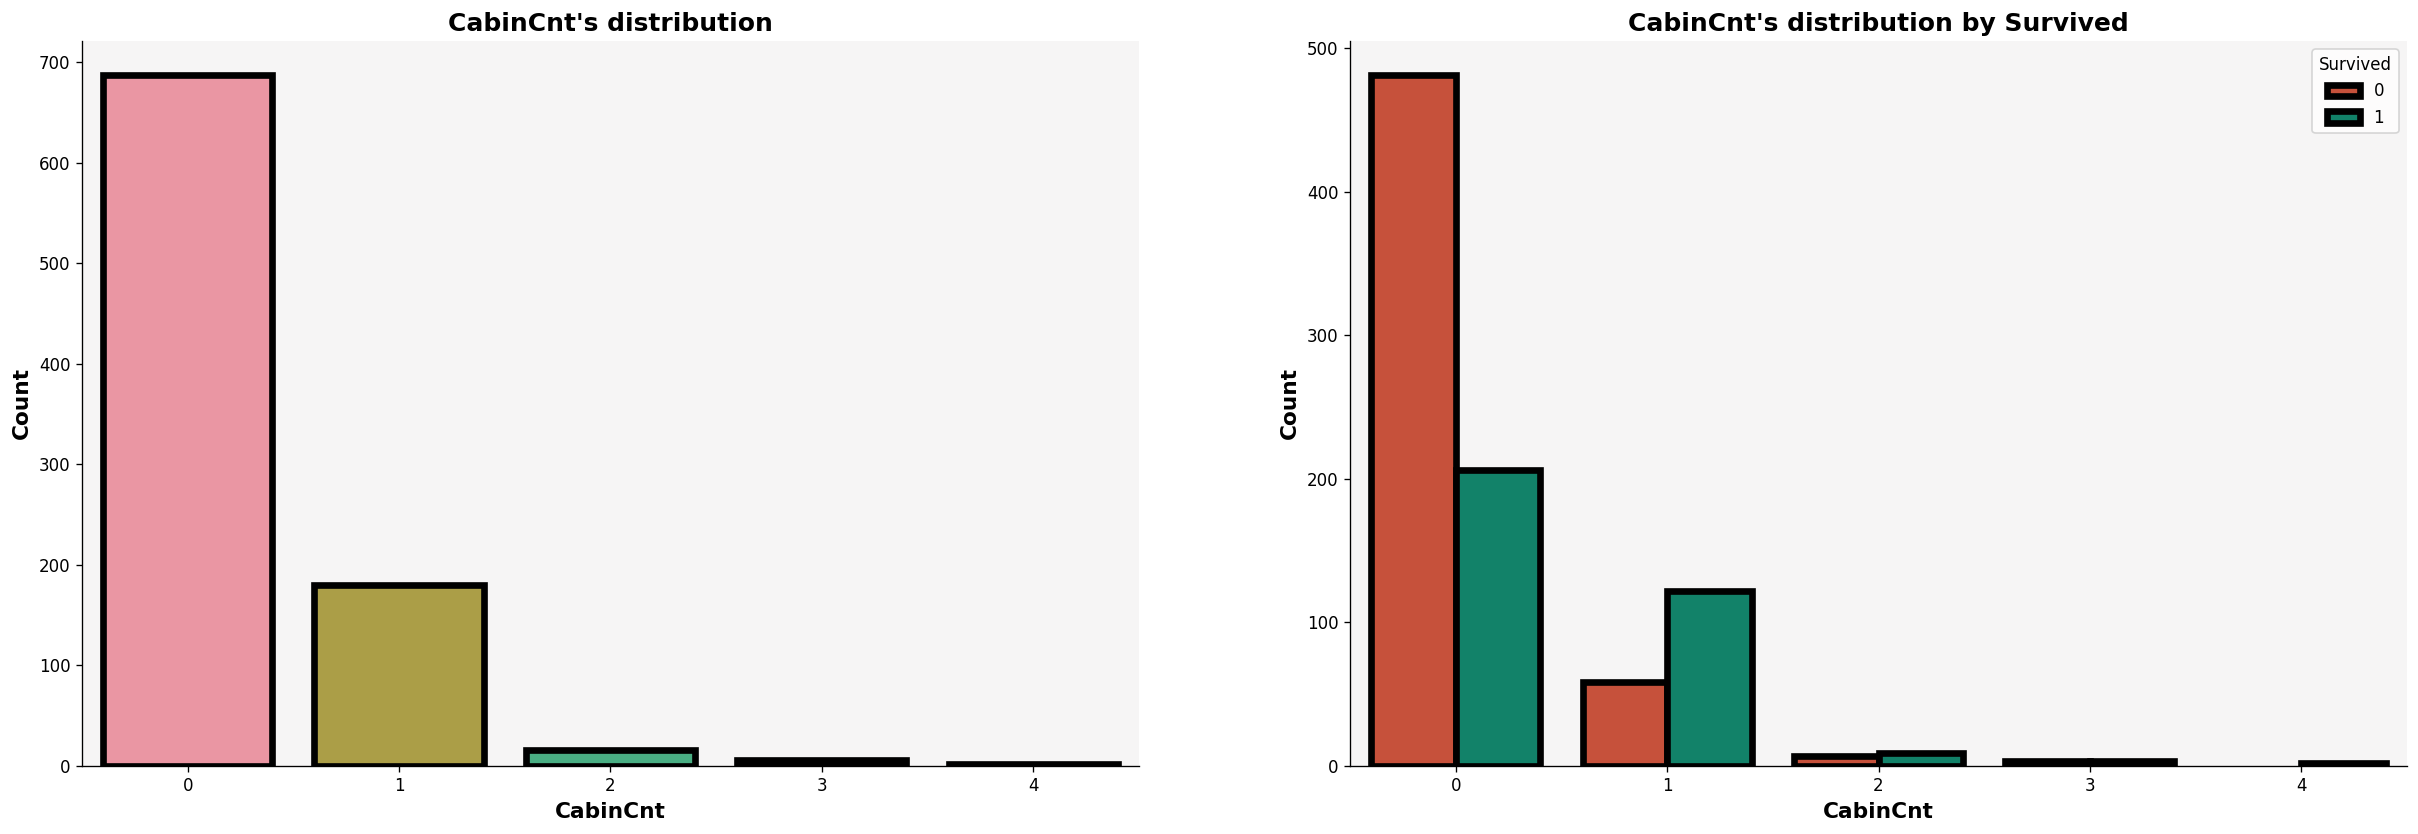

In [44]:
cat_dist(tmp_train, var='CabinCnt', hue='Survived', msg_show=False)

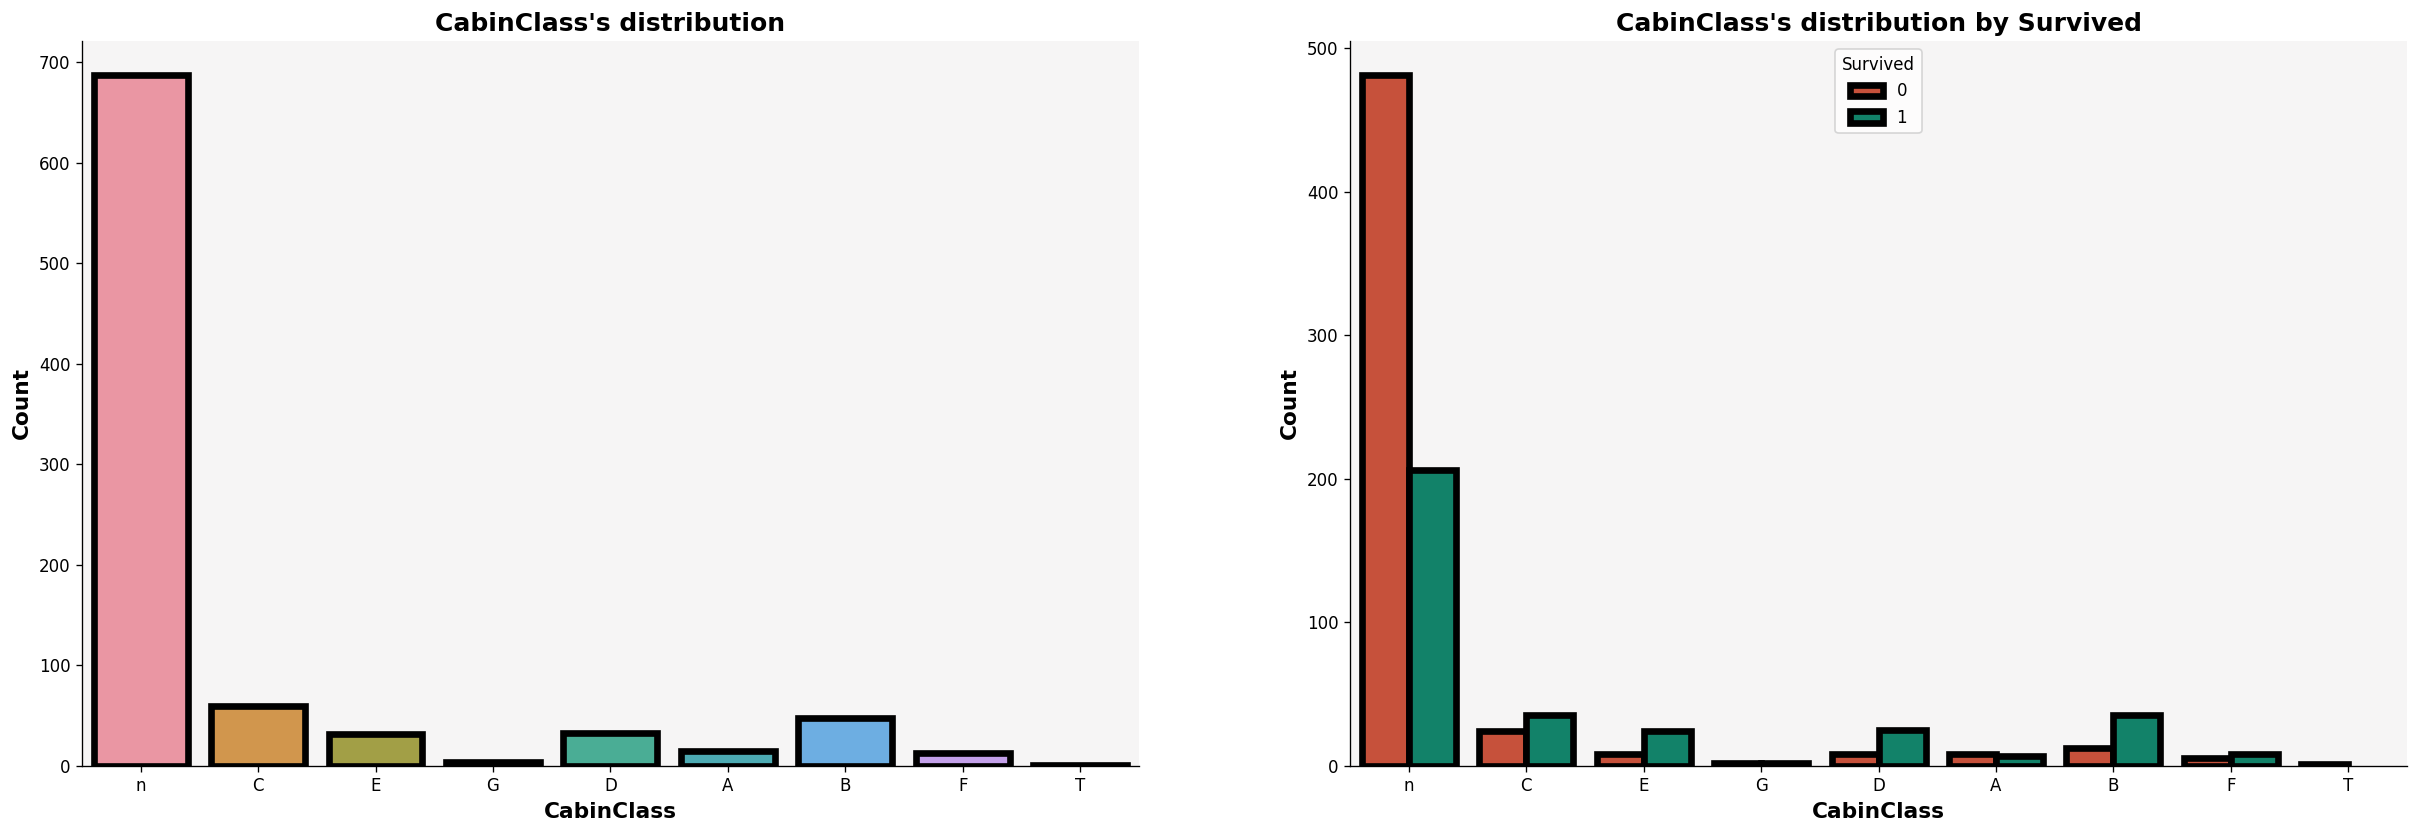

In [45]:
cat_dist(tmp_train, var='CabinClass', hue='Survived', msg_show=False)

In [46]:
tmp_train.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [47]:
tmp_train['IsNumericTicket'] = tmp_train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
tmp_train['TicketType'] = tmp_train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)

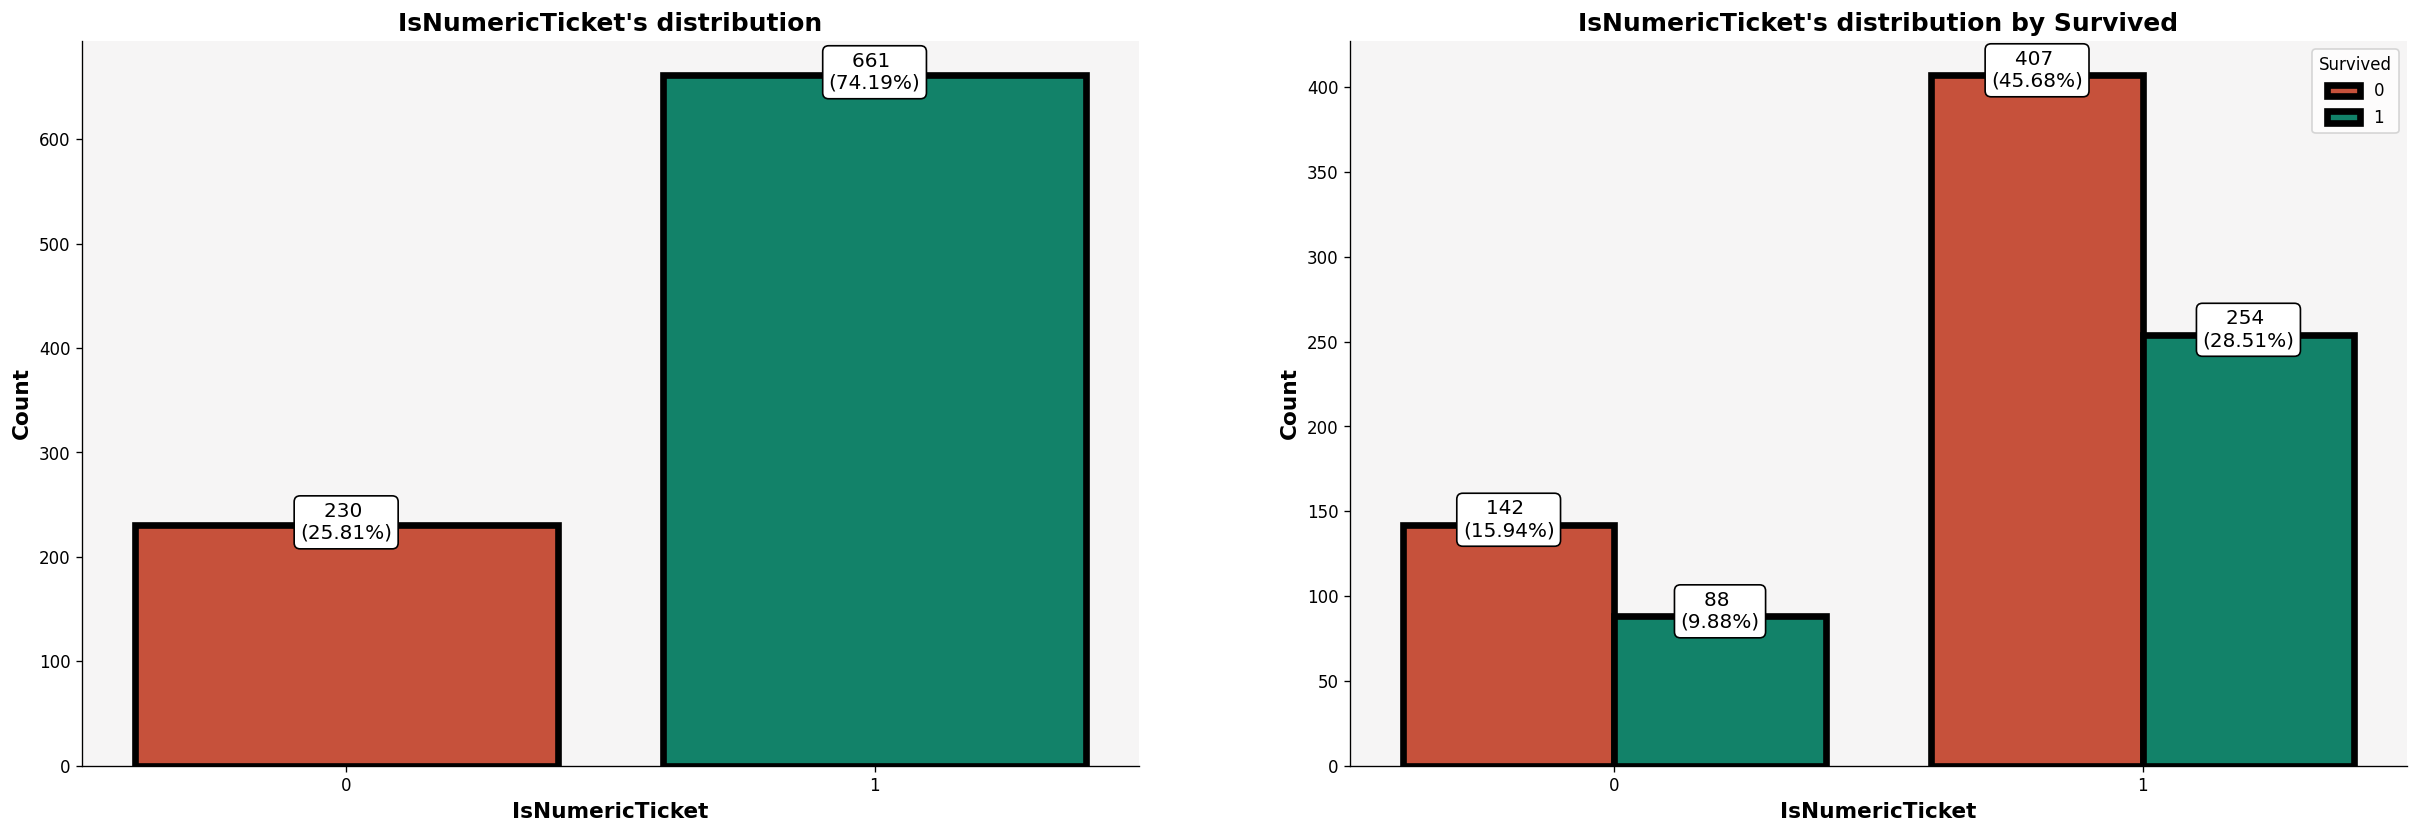

In [48]:
cat_dist(tmp_train, var='IsNumericTicket', hue='Survived')

In [49]:
pd.pivot_table(data=tmp_train, index='TicketType', values='Survived').T.style.background_gradient(axis=1)

TicketType,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,pc,pp,ppp,sc,sca4,scah,scahbasle,scow,scparis,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,0.383459,0.000000,0.095238,0.000000,0.400000,0.341463,0.000000,0.000000,0.000000,0.800000,0.650000,0.666667,0.500000,1.000000,0.000000,0.500000,1.000000,0.000000,0.454545,0.166667,0.000000,0.000000,0.000000,0.133333,0.000000,0.444444,1.000000,0.100000,0.333333


In [50]:
# missing values
all_data['Age'] = all_data.Age.fillna(train.Age.median())
all_data['Fare'] = all_data.Fare.fillna(train.Fare.median())
all_data.dropna(subset=['Embarked'], inplace=True)
cabins = all_data.Cabin
all_data.drop(['Cabin'], axis=1, inplace=True)

In [51]:
# derivative features
all_data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
all_data['IsNumericTicket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['TicketType'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['Title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Family'] = all_data.SibSp + all_data.Parch

In [52]:
# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
all_data[nominal_vars] = all_data[nominal_vars].astype('str')

for feature in numeric_vars:
    all_data[feature] = np.log1p(all_data[feature])

scaler = StandardScaler()
numeric_vars = all_data.columns[(all_data.dtypes != 'object') & (all_data.columns != 'PassengerId') & (all_data.columns != 'Survived') & (all_data.columns != 'IsTrain')]
all_data[numeric_vars] = scaler.fit_transform(all_data[numeric_vars])

In [53]:
# split data
all_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
data_dummies = pd.get_dummies(all_data)
X_train = data_dummies[data_dummies.Survived.notnull()].drop(['Survived'], axis=1)
y_train = data_dummies[data_dummies.Survived.notnull()].Survived
X_test = data_dummies[data_dummies.Survived.isnull()].drop(['Survived'], axis=1)

In [54]:
X_train.shape, y_train.shape, X_test.shape

((889, 76), (889,), (418, 76))

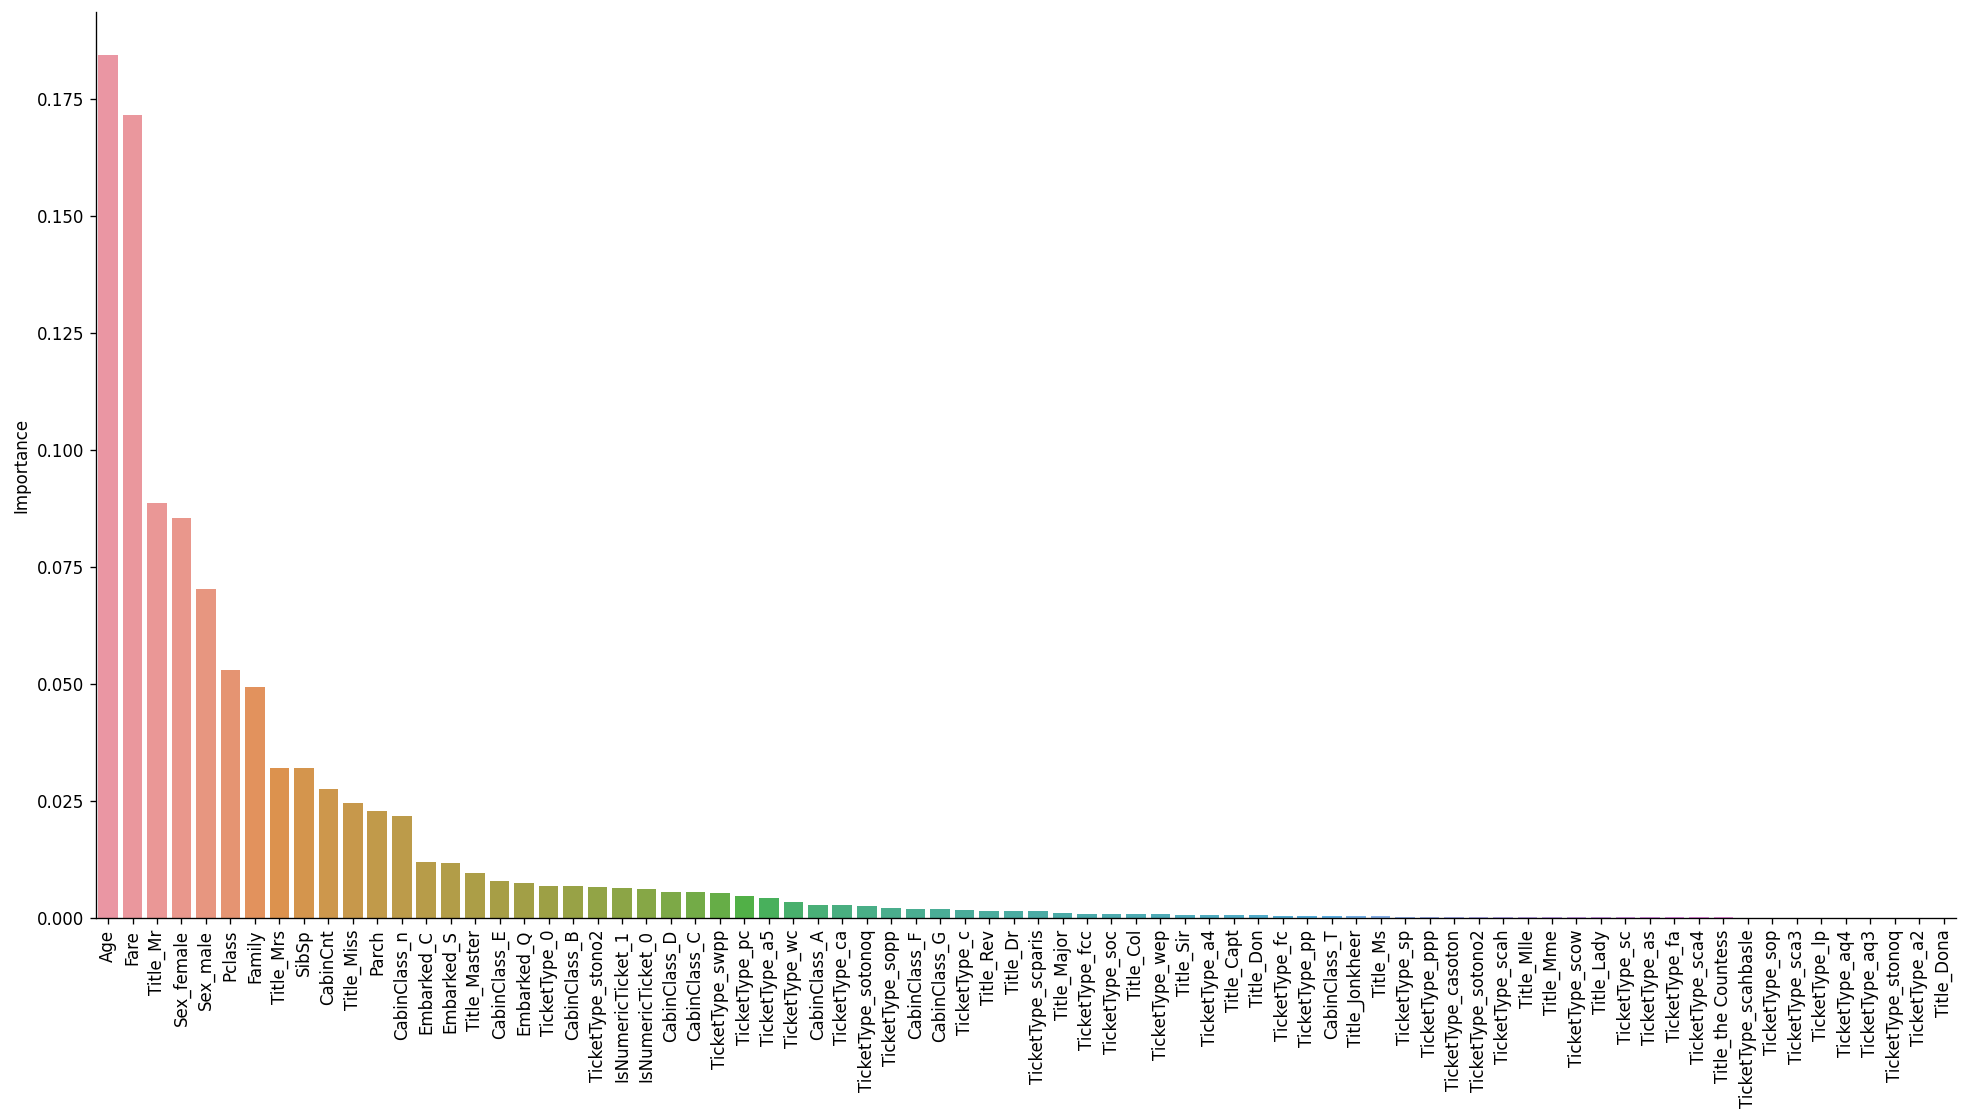

In [55]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
plt.show()

In [56]:
all_data.Title = all_data.Title.apply(lambda x: 'Others' if x in list(all_data.Title.value_counts()[all_data.Title.value_counts() < 8].index) else x)
all_data.TicketType = all_data.TicketType.apply(lambda x: 'Others' if x in list(all_data.TicketType.value_counts()[all_data.TicketType.value_counts() < 10].index) else x)

In [57]:
# split data2
data_dummies = pd.get_dummies(all_data)
X_train = data_dummies[data_dummies.Survived.notnull()].drop(['Survived'], axis=1)
X_test = data_dummies[data_dummies.Survived.isnull()].drop(['Survived'], axis=1)

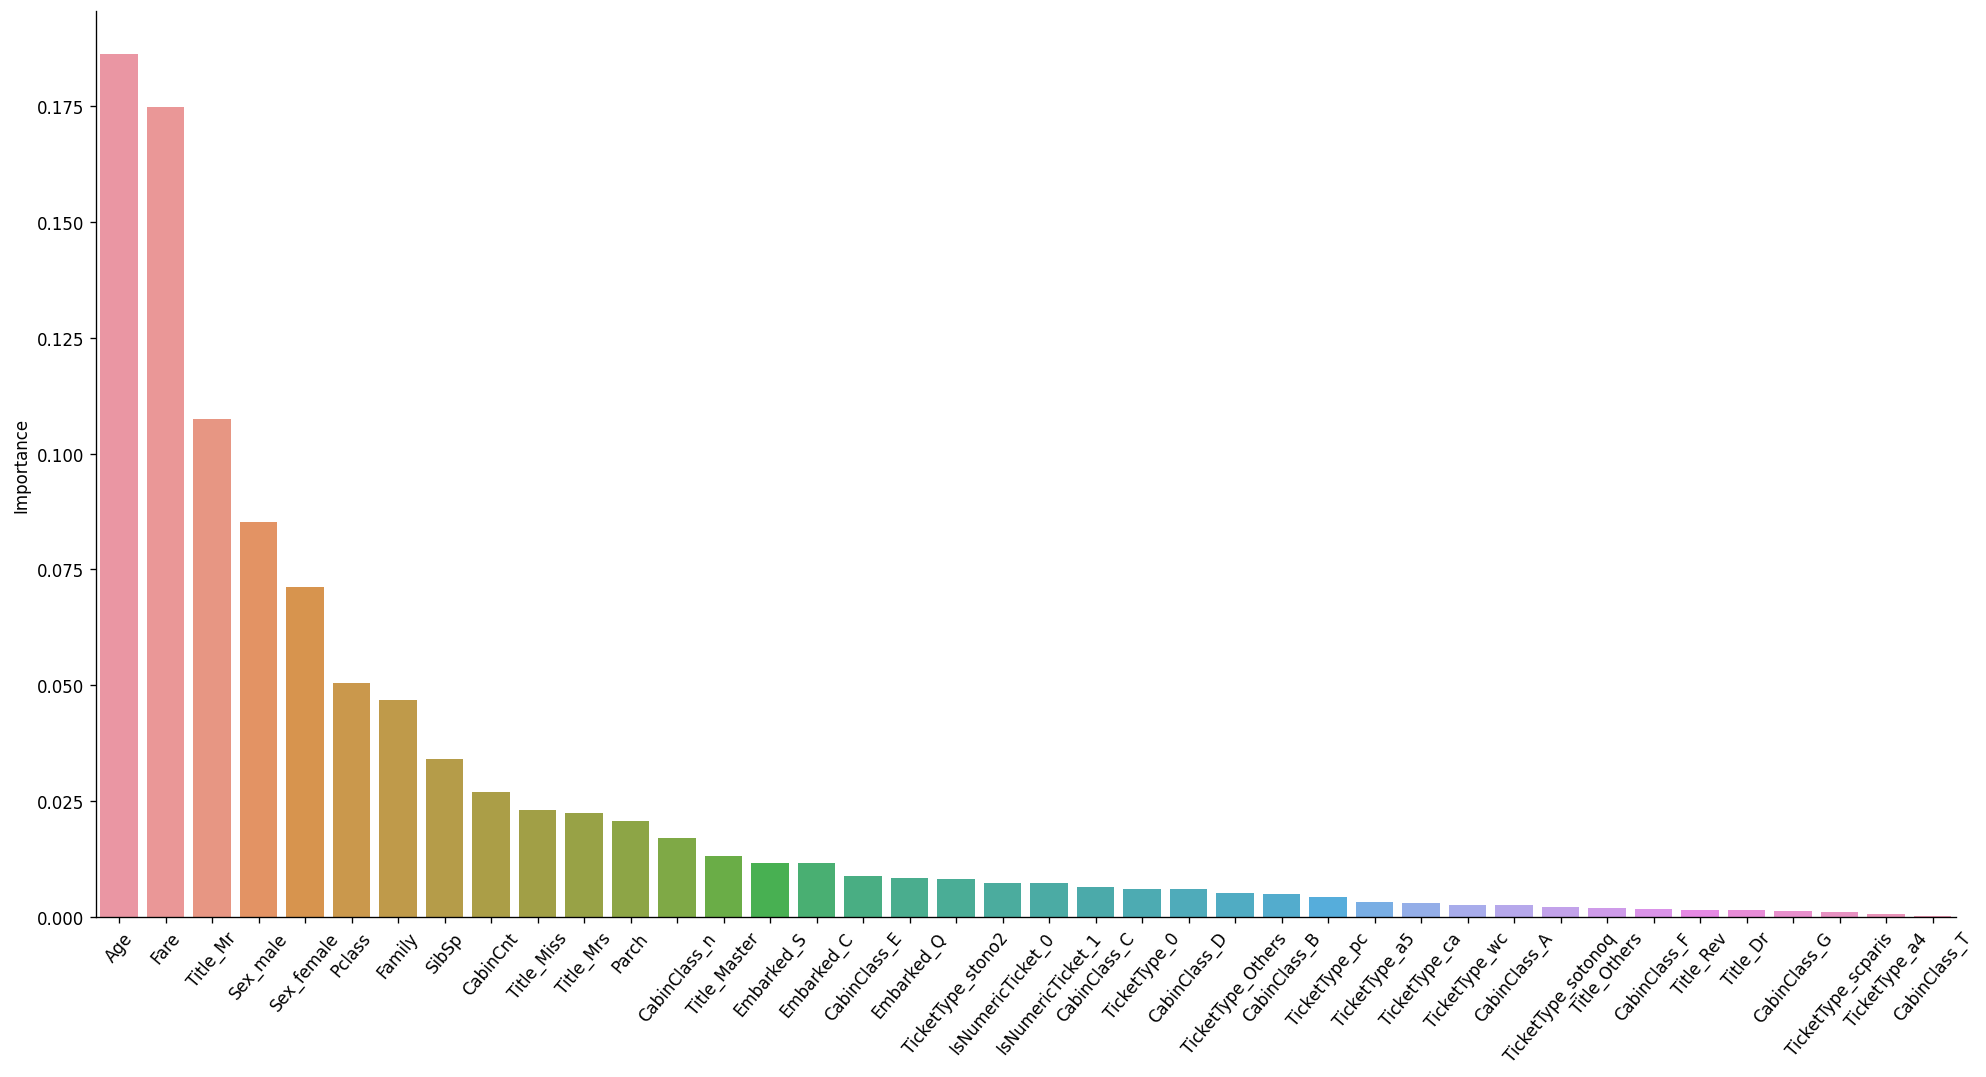

In [58]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 50)
plt.show()

In [61]:
#Modelling

allow_tuning = True

In [60]:
# This function is a function created by myself to eliminate repeated code generated by tuning XGBoost.
# params_grid_xgb: Combines fixed parameters for grid search in xgboost.
# features: Target features to be tuned using this function
# values: Search parameters for each feature
# X,y: Datasets.
# last: If this value is false, change each value of the GridSearchCV object's best_params to a list for immediate use in the next adjustment.
def xgb_gridsearch(params_grid_xgb, features, values, X, y, last=False):
    x_train, x_test = train_test_split(X, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y, test_size=.2, random_state=42)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    model_xgb = XGBClassifier(use_label_encoder = False, 
                              objective = 'binary:logistic')
    
    for i in range(len(features)):
        params_grid_xgb[features[i]] = values[i]
    search_xgb = GridSearchCV(model_xgb, params_grid_xgb, verbose = 0,
                              scoring = 'neg_log_loss', cv = cv).fit(x_train, y_train_tmp, early_stopping_rounds = 15, 
                                  eval_set = [[x_test, y_test_tmp]], 
                                  eval_metric = 'logloss', verbose = False)
    for i in range(len(features)):
        print(f"{features[i]}: {search_xgb.best_params_[features[i]]}")
    if not last:
        for k, v in search_xgb.best_params_.items():
            search_xgb.best_params_[k] = [v]
    return search_xgb, search_xgb.best_params_

In [62]:
if allow_tuning:
    params_knn = {
        'n_neighbors' : range(1, 10),
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree','kd_tree'],
        'p' : [1,2]
    }
    model_knn = knn()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_knn.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [63]:
if allow_tuning:
    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_logistic.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.08858667904100823, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [64]:
if allow_tuning:
    params_svc = [{'kernel': ['rbf'], 'gamma': [.01, .1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10, 100, 1000], 'probability': [True]},
                  {'kernel': ['poly'], 'degree' : [2, 3, 4, 5], 'C': [.01, .1, 1, 10, 100, 1000], 'probability': [True]}]
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

Fitting 5 folds for each of 59 candidates, totalling 295 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}


In [65]:
if allow_tuning:
    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 70, 'gamma': 0.0106, 'kernel': 'rbf', 'probability': True}


In [66]:
if allow_tuning:
    params_rf = {
        'n_estimators': range(100, 2000, 200),
        'criterion':['gini','entropy'],
        'bootstrap': [True, False],
        'max_depth': list(range(5, 100, 5)) + [None],
        'max_features': ['auto','sqrt', 5, 10],
        'min_samples_leaf': range(2, 11, 2),
        'min_samples_split': range(2, 11, 2)}
    model_rf = RandomForestClassifier()
    search_rf = RandomizedSearchCV(model_rf, params_rf, cv=5,
                                   scoring='accuracy', n_jobs=-1, verbose=1,
                                   n_iter=100).fit(X_train, y_train)
    print(search_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 1500, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 35, 'criterion': 'gini', 'bootstrap': True}


In [67]:
if allow_tuning:
    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion':['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11],
        'random_state': [734]}
    model_rf = RandomForestClassifier()
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    search_rf.best_params_['random_state']=242
    search_rf.best_estimator_.random_state=242
    print(search_rf.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 100, 'random_state': 242}


In [84]:
if allow_tuning:
    # Initial params.
    params_xgb = {'n_estimators': [1000],
                  'learning_rate': [0.1],
                  'max_depth': [5],
                  'min_child_weight': [1],
                  'gamma': [0],
                  'subsample': [0.8],
                  'colsample_bytree': [0.8],
                  'n_jobs': [-1],
                  'objective': ['binary:logistic'],
                  'use_label_encoder': [False],
                  'eval_metric': ['logloss'],
                  'scale_pos_weight': [1]}
    
    # learning rate tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb, 
                                            ['learning_rate'], 
                                            [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train)
    # max_depth, min_child_weight tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['max_depth', 'min_child_weight'],
                                            [range(3, 10), range(1, 6)],
                                            X_train, y_train)
    # gamma tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['gamma'],
                                            [[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['subsample', 'colsample_bytree'],
                                            [[i/100.0 for i in range(75,90,5)], [i/100.0 for i in range(75,90,5)]],
                                            X_train, y_train)
    
    # reg_alpha tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['reg_alpha'], 
                                            [[1e-5, 1e-2, 0.1, 1, 100]], 
                                            X_train, y_train)
    
    # learning rate re tuning.
    params_xgb['n_estimators'] = [5000]
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['learning_rate'],
                                            [[0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train, last=True)

    x_train, x_test = train_test_split(X_train, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y_train, test_size=.2, random_state=42)
    model_xgb = XGBClassifier(**params_xgb)
    
    # n_estimators tuning.
    model_xgb = model_xgb.fit(x_train, y_train_tmp, eval_set=[(x_test, y_test_tmp)], eval_metric=['logloss'], early_stopping_rounds=15, verbose=0)
    search_xgb.best_estimator_.n_estimators = model_xgb.best_iteration

learning_rate: 0.07
max_depth: 5
min_child_weight: 1
gamma: 0.4
subsample: 0.8
colsample_bytree: 0.8
reg_alpha: 1e-05
learning_rate: 0.07


In [85]:
if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    model_xgb = search_xgb.best_estimator_
else:
    model_knn = knn(algorithm='auto', 
                    n_neighbors=9,
                    p=1, 
                    weights='uniform')
    
    model_logistic = LogisticRegression(C=0.08858667904100823,
                                        max_iter=2000, 
                                        penalty='l2', 
                                        solver='liblinear')
    model_svc = SVC(C=70,
                    gamma=0.0106,
                    kernel='rbf',
                    probability=True)
    
    model_rf = RandomForestClassifier(bootstrap=True,
                                      criterion='entropy',
                                      max_depth=50, max_features=6, 
                                      min_samples_leaf=1, 
                                      min_samples_split=10, 
                                      n_estimators=100,
                                      random_state=734)
    
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.8,gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=15, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': model_xgb
}

In [86]:
import copy

# goal: The number of models to combine.
# estimaors: empty list.
# voting: voting method.
def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()

In [87]:
# create voting models
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

In [88]:
# Dictionary for storing results for each model.
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [89]:
# Cross-validation progresses for all models.
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train,y_train,cv=5).mean()

In [90]:
result_by_model.sort_values('score', ascending=False).reset_index(drop=True)

,model name,model,score
0,hard_logistic_svc_rf,"VotingClassifier(estimators=[('logistic',\n ...",0.840303
1,hard_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.840291
2,hard_knn_svc_rf,"VotingClassifier(estimators=[('knn', KNeighbor...",0.835815
3,hard_svc_xgb,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.835790
4,hard_rf_xgb,"VotingClassifier(estimators=[('rf',\n ...",0.835784
5,hard_svc_rf,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.834685
6,hard_knn_svc_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.834666
7,soft_rf_xgb,"VotingClassifier(estimators=[('rf',\n ...",0.834660
8,svc,"SVC(C=70, gamma=0.0106, probability=True)",0.833562
9,hard_knn_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.833549


In [91]:
model_name = 'rf'
models[model_name].fit(X_train, y_train)
y_pred = models[model_name].predict(X_test).astype('int')

submission = pd.DataFrame({'PassengerId': test.PassengerId, 
                              'Survived': y_pred})

submission.to_csv('submission.csv', index = False)